In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from tqdm import tqdm
#from sklearn_extra.cluster import CLARA
from scipy.signal import welch

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### Lectura de archivos

In [19]:
ocean_beach = pd.read_csv('../data/ocean/Australia/Torbay01.wst', sep='\s+', header=None)
torbay = pd.read_csv('../data/ocean/Australia/OBDEP01.wst', sep='\s+', header=None)

<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:1: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_2264437/457389057.py:1: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_2264437/457389057.py:2: SyntaxWarning:

invalid escape sequence '\s'



In [5]:
ocean_beach

0     1       2    3
0           1     1   1.997  0.0
1           1     2   1.963  0.0
2           1     3   1.815  0.0
3           1     4   1.631  0.0
4           1     5   1.171  0.0
...       ...   ...     ...  ...
7771195  1619  4796  32.809  0.0
7771196  1619  4797  32.553  0.0
7771197  1619  4798  32.270  0.0
7771198  1619  4799  32.045  0.0
7771199  1619  4800  31.927  0.0

[7771200 rows x 4 columns]

### Visualización fragmento serie temporal

#### Ocean beach

(4800, 4)

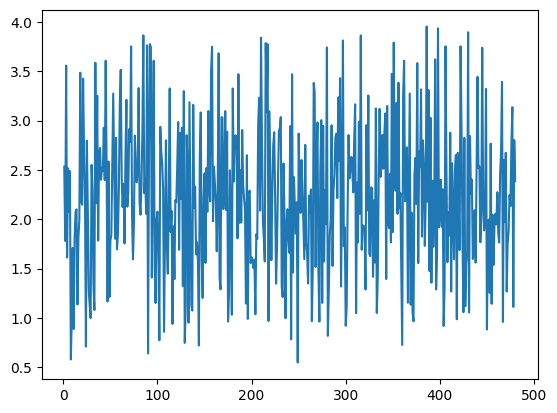

In [14]:
o1 = ocean_beach[ocean_beach[0] == 2]
plt.plot(o1[1][:480], o1[2][:480])
ocean_beach[ocean_beach[0] == 1].shape


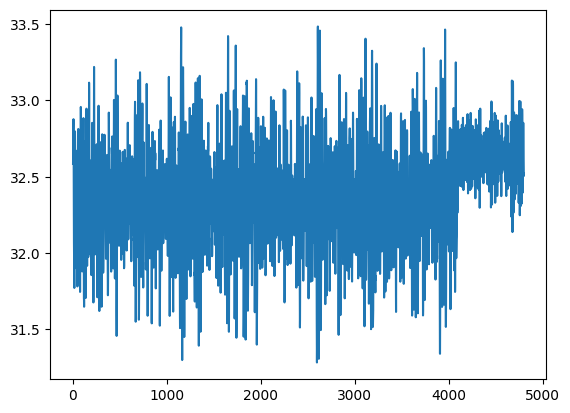

In [16]:
o2 = ocean_beach[ocean_beach[0] == 17]
plt.plot(o2[1], o2[2])

#### Torbay

/tmp/ipykernel_2264437/1965963464.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



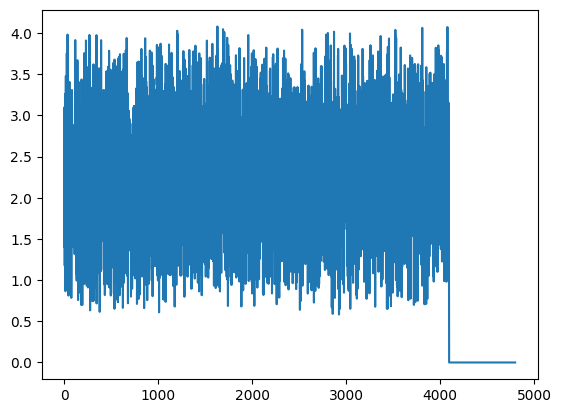

In [20]:
o1 = torbay[ocean_beach[0] == 2]
plt.plot(o1[1], o1[2])

/tmp/ipykernel_2264437/2689900452.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



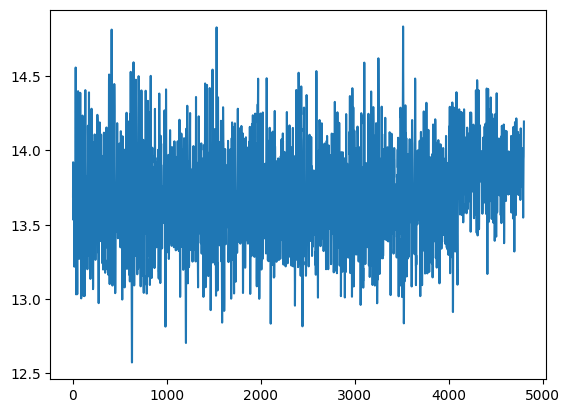

In [21]:
o2 = torbay[ocean_beach[0] == 17]
plt.plot(o2[1], o2[2])

### Creación del archivo de espectro de energía

In [6]:
def crear_espectro_ssh():
    # SET PARAMETERS
    Fs = 2  # Sampling frequency (Hz)
    T = 1 / Fs  # Sampling period (s)
    L = 4800  # Number of samples in a single burst
    t = L * T  # Burst length (s)

    # LOAD DATA
    data = pd.read_csv('../data/Australia/Torbay01.wst', sep='\s+', header=None)
    data.columns = ['Burst', 'Sample', 'SSH', 'Pressure']

    # PREPARE TABLE FOR OUTPUT
    spectra = pd.DataFrame(index=range(data['Burst'].max()), columns=range(int(L / 2) + 1))
    spectraName = 'Torbay01_spectra.txt'

    # PROCESS DATA BURST BY BURST
    for n in tqdm(range(min(data['Burst']), max(data['Burst']) + 1), desc="Procesando Bursts"):
        # Filter data for the current burst
        df = data[data['Burst'] == n]
        df = df.reset_index(drop=True)

        # REMOVE TRENDS (SLOWLY-VARYING COMPONENTS)
        # Fit a 2nd order polynomial to the SSH data and subtract it
        time = range(L)  # Time vector [0:1:1023]
        ssh_trend = np.polyfit(time, df['SSH'], 2)  # Polynomial fit
        S1 = df['SSH'] - np.polyval(ssh_trend, time)  # Remove trend

        # CALCULATE WAVE SPECTRA
        S1 = S1.to_numpy()
        Y = fft(S1)  # Fast Fourier Transform
        f = np.r_[:int(L / 2 + 1)] * Fs / L  # Frequency vector [0:d_f:0.5]
        d_f = f[1] - f[0]  # Frequency interval
        P2 = abs(Y)
        P1 = P2[:int(L / 2 + 1)]**2 / (Fs * L)  # Energy density spectrum
        P1[1:-1] = 2 * P1[1:-1]  # Adjust for energy conservation

        # SAVE OUTPUT FOR THIS BURST
        spectra.loc[n - 1, :] = P1.round(6)

    # SAVE ALL BURSTS TO FILE
    spectra.to_csv(spectraName, index=False)

In [7]:
crear_espectro_ssh()

Procesando Bursts: 100%|██████████████████████████████████████████████████████████████████████████████| 1619/1619 [00:13<00:00, 123.30it/s]


In [92]:
data = np.load('../data/Australia/OBDEP01.npy')
freq = np.load('../data/Australia/freq.npy')

In [96]:
data.shape

(1559, 88, 1)

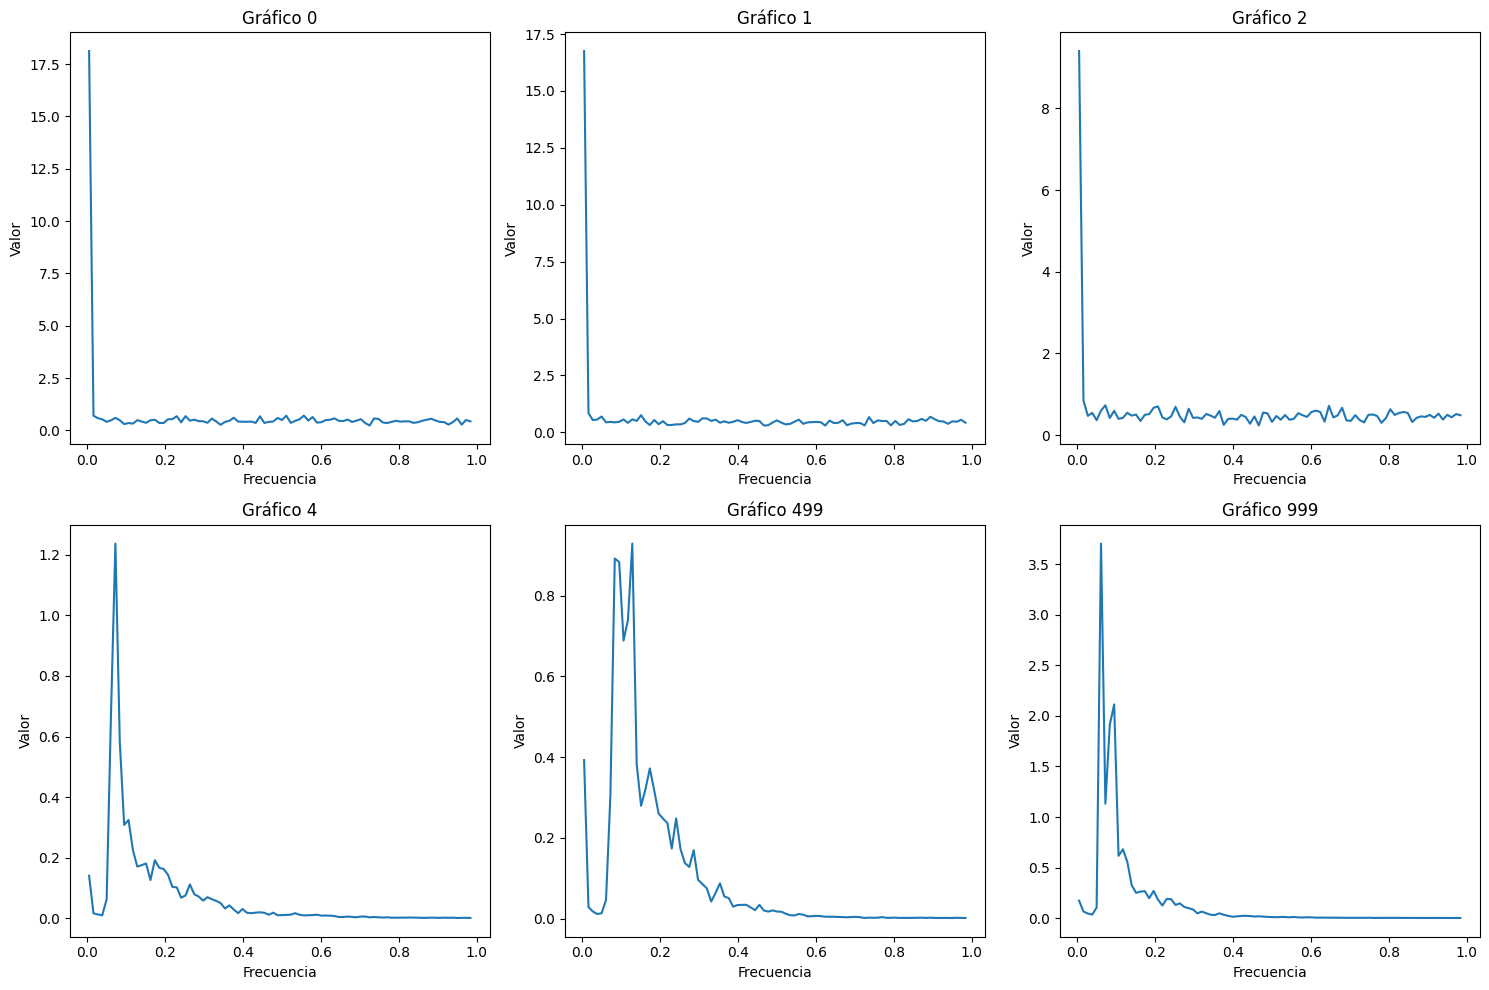

In [109]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Crear el grid de subplots

idx = [0, 1, 2, 4, 499, 999]  # Índices de los gráficos

# Asegúrate de que `axes` sea un arreglo aplanado para fácil acceso
axes = axes.flatten()

for k, i in enumerate(idx):
    # Simular los datos a graficar (ajusta esto según tu estructura de datos)
    em = data[i, :, 0]  # Aquí asumo que `data` tiene 3 dimensiones (filas, columnas, capa)

    # Seleccionar el subplot correspondiente
    ax = axes[k]
    ax.plot(freq, em)

    # Añadir título y etiquetas a cada gráfico
    ax.set_title(f'Gráfico {i}')
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Valor')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el grid de gráficos
plt.show()


---

### Creación del espectro con Welch

In [8]:
ocean_beach = pd.read_csv('../data/Australia/Torbay01.wst', sep='\s+', header=None)
fs = 2.0

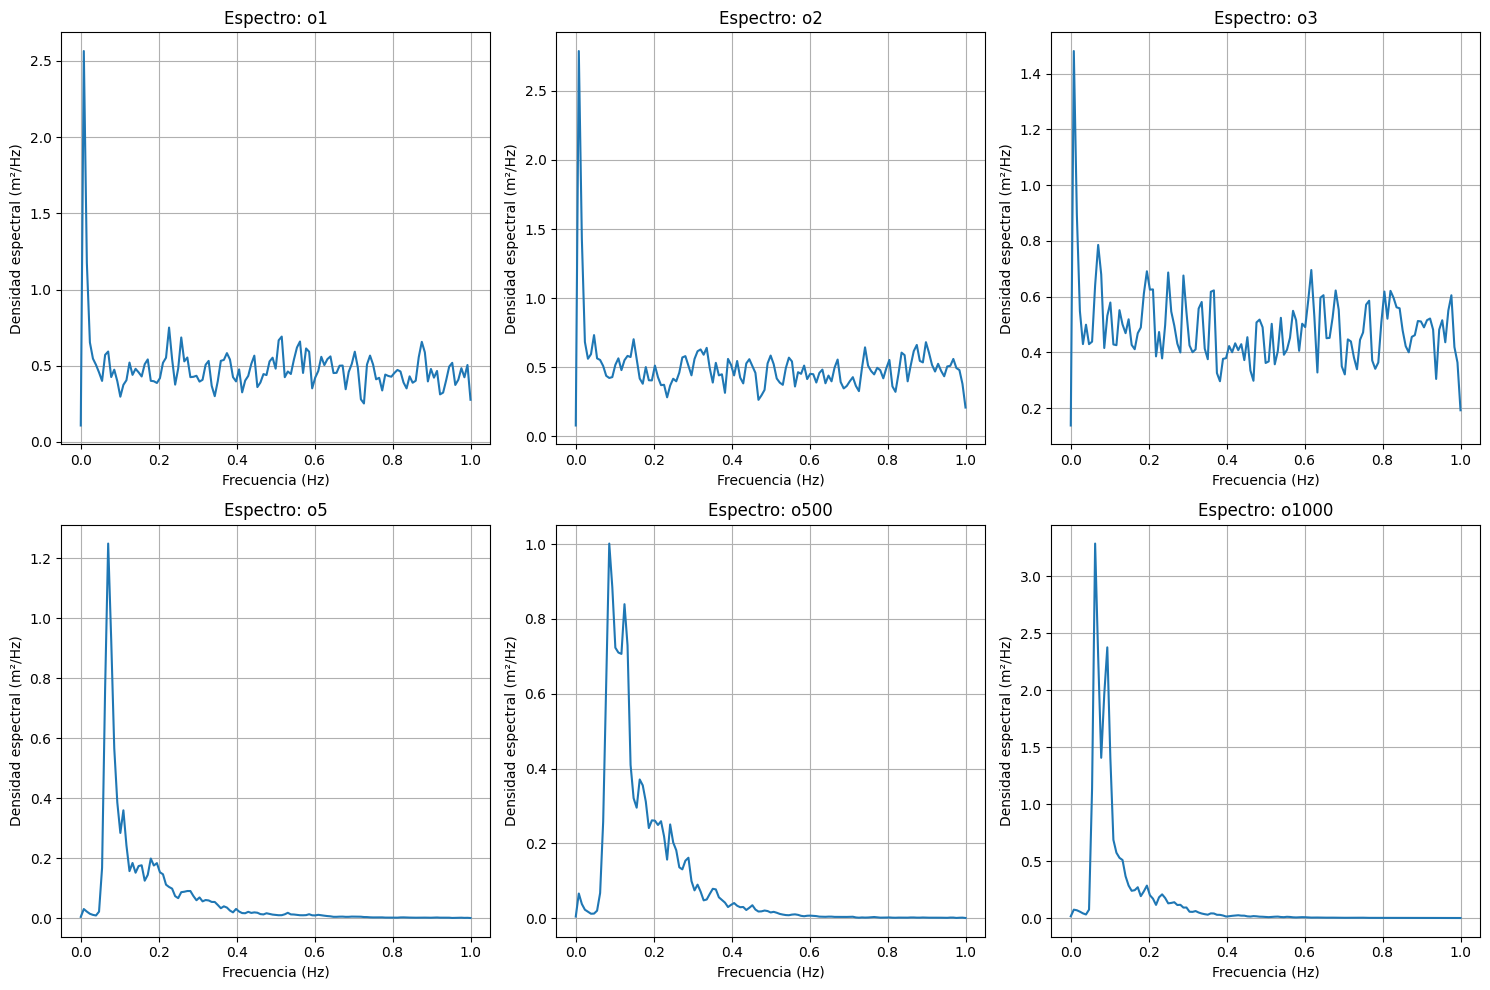

In [109]:
o1 = ocean_beach[ocean_beach[0] == 1]
o2 = ocean_beach[ocean_beach[0] == 2]
o3 = ocean_beach[ocean_beach[0] == 3]
o5 = ocean_beach[ocean_beach[0] == 5]
o50 = ocean_beach[ocean_beach[0] == 500]
o100 = ocean_beach[ocean_beach[0] == 1000]

datasets = [o1, o2, o3, o5, o50, o100]
labels = ["o1", "o2", "o3", "o5", "o500", "o1000"]

# Frecuencia de muestreo
fs = 2.0  # Ajustar a tu intervalo de muestreo real

# Crear el grid plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 filas, 3 columnas
axes = axes.flatten()  # Aplanar para iterar fácilmente

for i, (data, label, ax) in enumerate(zip(datasets, labels, axes)):
    # Cálculo del espectro con Welch
    frequencies, Pxx = welch(data[2], fs, nperseg=256)
    
    # Graficar en el subplot correspondiente
    ax.plot(frequencies, Pxx)
    ax.set_title(f"Espectro: {label}")
    ax.set_xlabel("Frecuencia (Hz)")
    ax.set_ylabel("Densidad espectral (m²/Hz)")
    ax.grid()

# Ajustar diseño
plt.tight_layout()
plt.show()

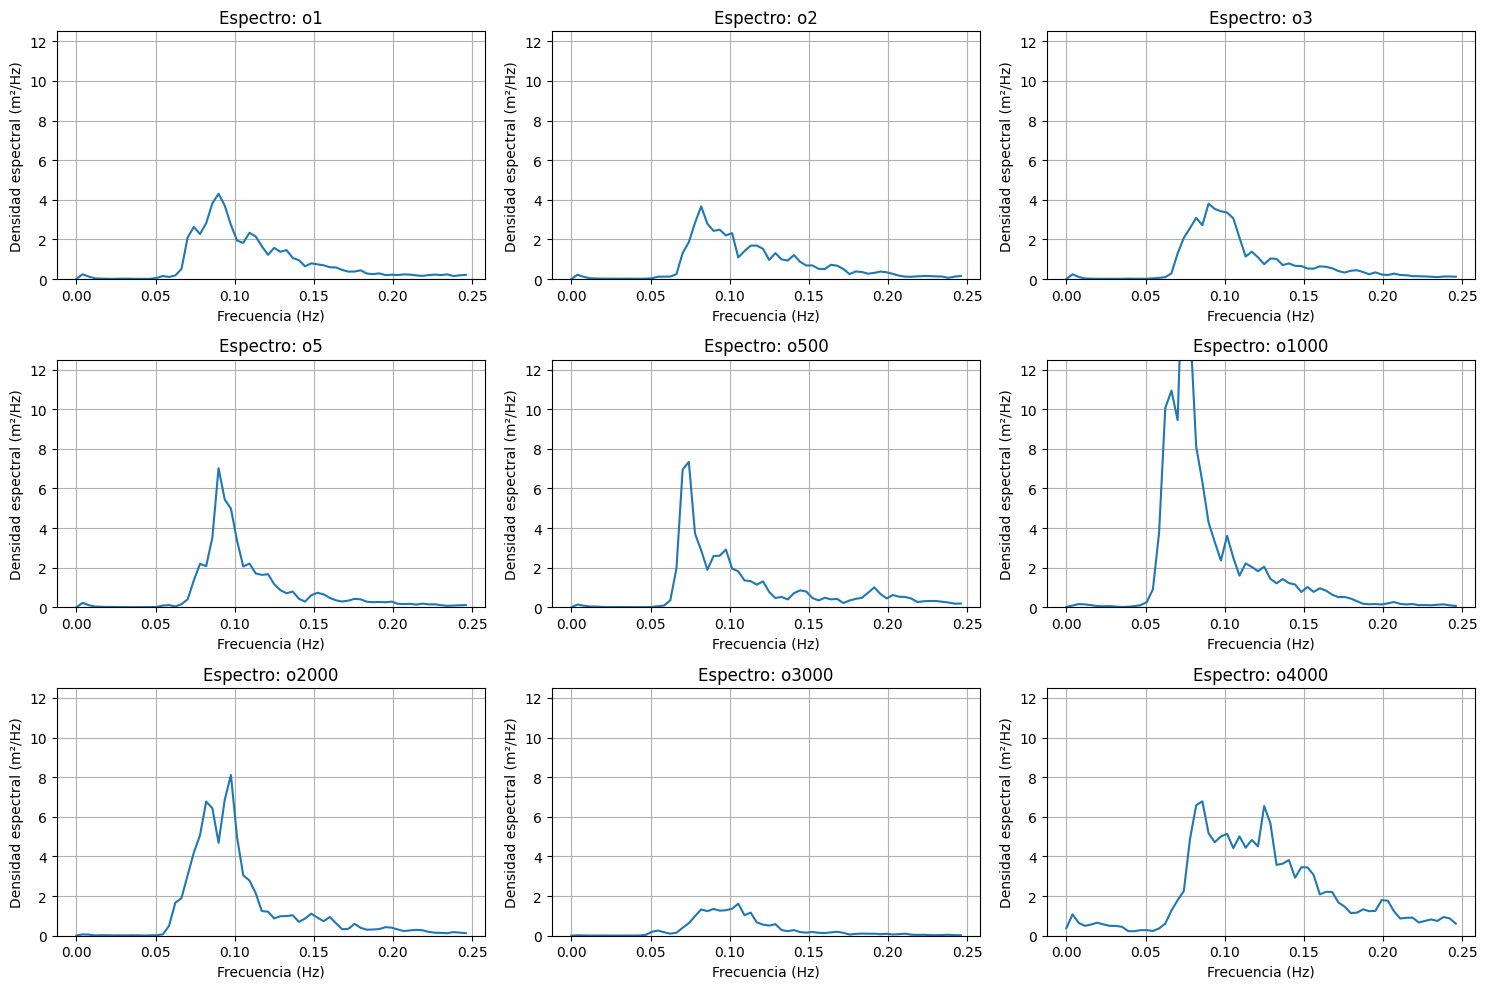

(257,)

In [62]:
o1 = ocean_beach[ocean_beach[0] == 4]
o2 = ocean_beach[ocean_beach[0] == 5]
o3 = ocean_beach[ocean_beach[0] == 6]
o5 = ocean_beach[ocean_beach[0] == 7]
o50 = ocean_beach[ocean_beach[0] == 50]
o100 = ocean_beach[ocean_beach[0] == 100]
o200 = ocean_beach[ocean_beach[0] == 200]
o300 = ocean_beach[ocean_beach[0] == 500]
o400 = ocean_beach[ocean_beach[0] == 1000]

datasets = [o1, o2, o3, o5, o50, o100, o200, o300, o400]
labels = ["o1", "o2", "o3", "o5", "o500", "o1000", "o2000", "o3000", "o4000"]

# Frecuencia de muestreo
fs = 2.0  # Ajustar a tu intervalo de muestreo real

# Crear el grid plot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 2 filas, 3 columnas
axes = axes.flatten()  # Aplanar para iterar fácilmente

for i, (data, label, ax) in enumerate(zip(datasets, labels, axes)):
    # Cálculo del espectro con Welch
    fs_ = 2.0
    nperseg = 256 * fs_
    frequencies, Pxx = welch(data[2], fs, nperseg=nperseg)
    
    # Graficar en el subplot correspondiente
    ax.plot(frequencies[:int(nperseg//8)], Pxx[:int(nperseg//8)])
    ax.set_title(f"Espectro: {label}")
    ax.set_xlabel("Frecuencia (Hz)")
    ax.set_ylabel("Densidad espectral (m²/Hz)")
    ax.set_ylim(0,12.5)
    ax.grid()

# Ajustar diseño
plt.tight_layout()

plt.show()
frequencies.shape

In [63]:
bursts = ocean_beach[0].unique()

data = []

for burst in bursts:
    frequencies, Pxx = welch(ocean_beach[ocean_beach[0] == burst][2], fs, nperseg=256 * 2.0)
    menos4 = len(frequencies[frequencies < 0.04])
    
    data.append(Pxx[menos4:])


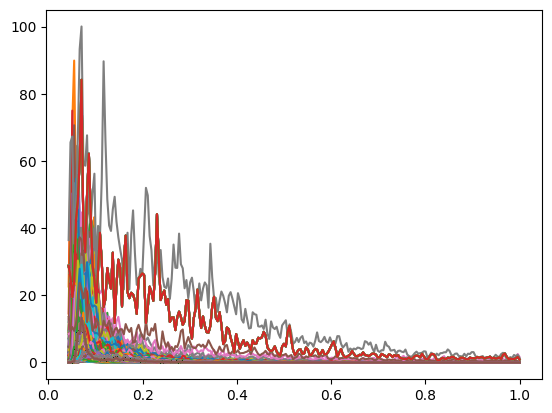

In [73]:
plt.plot(frequencies[frequencies > 0.04], np.array(data[:,:,0].T))
plt.show()

In [66]:
data = np.array(data[3:])
data = data[:, :, np.newaxis]

In [12]:
menos4 = len(frequencies[frequencies < 0.04])
freq = frequencies[menos4:]

In [13]:
np.save('Torbay01.npy', data)
np.save('freq.npy', freq)

---

## Clustering

In [51]:
data = np.load('../data/Australia/OBDEP01.npy')
freq = np.load('../data/Australia/freq.npy')

In [52]:
num_samples, num_obs_per_sample, num_outputs = data.shape

In [ ]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data[:,:,0] @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.5) & (hs < 2.5))[0]
#chosen_indexes = np.arange(0, num_samples)
print("How much spectra falls in the range 0.5-3.0 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()

Shape of hs: (1616, 1)
How much spectra falls in the range 0.5-3.0 Hs: 1166


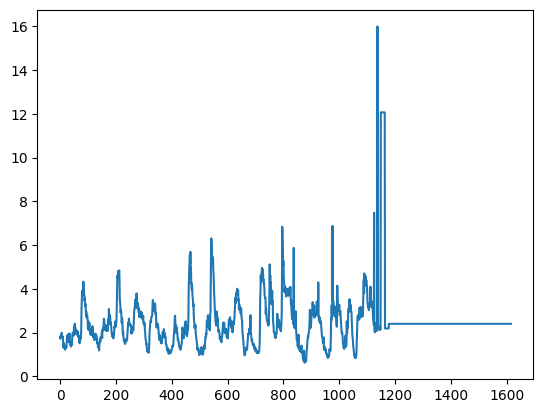

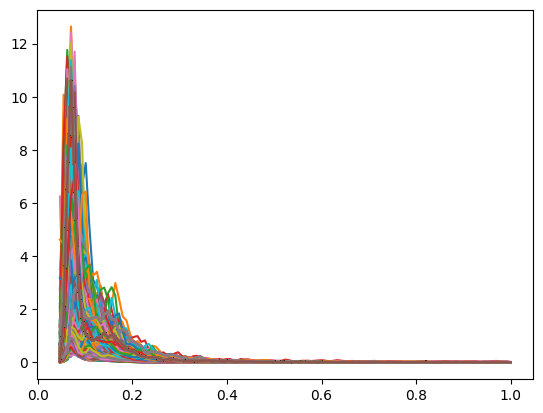

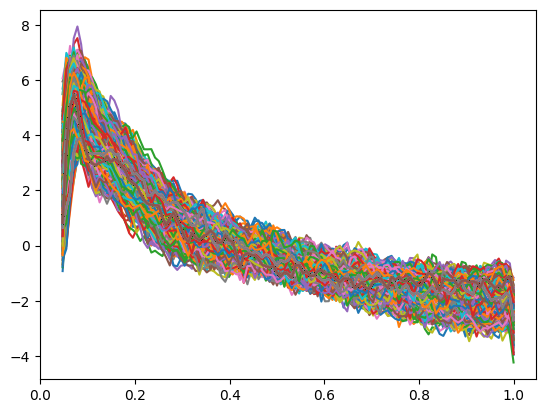

In [110]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data[:,:,0] @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.5) & (hs < 2.5))[0]
#chosen_indexes = np.arange(0, num_samples)
print("How much spectra falls in the range 0.5-3.0 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()

In [12]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(1513, 123, 1)


In [13]:
chosen_indexes = np.where((freq > 0) & (freq <= 0.5))[0]

#Select indexes
freq = freq[chosen_indexes]
print("Shape of the data: ")
print(freq.shape)

Shape of the data: 
(59,)


### Ocean beach

In [8]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.2
# 13 clusters
std_dif = std_dif * 0.1
# std_dif = std_dif * 0.075
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.08509738998445347
Gamma estimated: 0.08509738998445347
Final sigma: 0.017019477996890697
Final gamma: 0.008509738998445348
Final sigma bound: (1.7019477996890697e-09, 0.0017019477996890698)
Final gamma bound: (8.509738998445349e-12, 0.0008509738998445349)


### Ocean Beach logarítmico

In [14]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(np.log(data + 1e-6), n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.1
# 13 clusters
std_dif = std_dif * 0.01
# std_dif = std_dif * 0.075
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.5736480322520611
Gamma estimated: 0.5736480322520611
Final sigma: 0.05736480322520611
Final gamma: 0.0057364803225206104
Final sigma bound: (5.736480322520611e-09, 0.005736480322520611)
Final gamma bound: (5.736480322520611e-12, 0.0005736480322520611)


### Torbay

In [38]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.05
std_dif = std_dif * 0.005
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.3019589595523371
Gamma estimated: 0.3019589595523371
Final sigma: 0.015097947977616856
Final gamma: 0.0015097947977616856
Final sigma bound: (1.5097947977616855e-09, 0.0015097947977616858)
Final gamma bound: (1.5097947977616857e-12, 0.00015097947977616856)


### Torbay logarítmico

In [117]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(np.log(data + 1e-6), n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.05
# 13 clusters
std_dif = std_dif * 0.005
# std_dif = std_dif * 0.075
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.7361472951141128
Gamma estimated: 0.7361472951141128
Final sigma: 0.03680736475570564
Final gamma: 0.0036807364755705643
Final sigma bound: (3.680736475570564e-09, 0.0036807364755705643)
Final gamma bound: (3.680736475570565e-12, 0.00036807364755705644)


In [15]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 1.0
ini_lengthscale = 1e-2
bound_lengthscale = (1e-7, 5e-1)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq).T
x_train = np.atleast_2d(freq).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

(59, 1)


In [16]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=10, free_deg_MNIV=20)

logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, logdata[:num_samples,0:len(freq),[0]])

Group responsability estimated: [1513    0]
---Kernel estimated---
1.1**2 * RBF(length_scale=0.0135) + WhiteKernel(noise_level=0.00541)

-----------Lead 1-----------
Step 1/10- Trying to divide: 0 with beat 215
---Kernel estimated---
1.2**2 * RBF(length_scale=0.0148) + WhiteKernel(noise_level=0.00545)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([1362.8423,  160.3087])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([1362.8423,  160.3087])
ELBO_reduction: 0.0
Sum resp_temp: tensor([1362.8423,  160.3087])
Q_bas: tensor(-48258.3184), Q_lat: tensor(-560478.0963), Elbo_bas: tensor([-562645.6981])
Q_bas_post: tensor(-46817.8905), Q_lat: tensor(-475043.7147), Elbo_post: tensor([-477584.1270])
Chosen to divide: 0 with beat 215
First resp: tensor([1362.8423,  160.3087])

-----------Lead 1-----------

   -----------Model 1----------

Step 1/10- Trying to divide: 1 with beat 854
---Kernel estimated---
1.06**2 * RBF(length_scale=0.0148) + WhiteKernel(noise_level=0.00532)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------
Current resp: tensor([639.1653, 321.7430, 215.1997, 198.0417, 143.0003])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------
Current resp: tensor([639.1653, 321.7430, 215.1997, 198.0417, 143.0003])
ELBO_reduction: 0.0
Sum resp_temp: tensor([639.1653, 321.7430, 215.1997, 198.0417, 143.0003])
Q_bas: tensor(-42700.8404), Q_lat: tensor(-280592.0113), Elbo_bas: tensor([-281347.9506])
Q_bas_post: tensor(-41351.0946), Q_lat: tensor(-251529.0237), Elbo_post: tensor([-255096.4275])
Chosen to divide


-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------
Sum resp_temp: tensor([447.5236, 359.1875, 212.1424, 185.0066, 153.0052, 104.0003,  54.0003,
          0.0000])
Q_bas: tensor(-39414.6468), Q_lat: tensor(-210371.7531), Elbo_bas: tensor([-210907.9515])
Q_bas_post: tensor(-39400.4745), Q_lat: tensor(-210873.1124), Elbo_post: tensor([-211417.0067])
Possibly better q_obs but worse elbo.
Not reallocating, trying to generate new group.
Step 1/10- Trying to divide: 5 with beat 215
---Kernel estimated---
0.465**2 * RBF(length_scale=0.0111) + WhiteKernel(noise_level=0.00547)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----

---Kernel estimated---
1.08**2 * RBF(length_scale=0.0127) + WhiteKernel(noise_level=0.00533)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------
Current resp: tensor([450.0819, 299.1316, 213.3012, 153.0000, 124.0052, 104.0013,  89.0000,
         50.0001,  33.0000])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------
Current resp: tensor([450.0819, 299.1316, 213.3012, 153.0000, 124.0052, 104.0013,  89.0000,
  

ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------
Current resp: tensor([453.1883, 285.0989, 211.2110, 133.0705, 109.0000, 100.0001,  96.2825,
         70.0000,  30.0002,  26.0000,   1.0000])
ELBO_reduction: 0.0
Sum resp_temp: tensor([453.1883, 285.0989, 211.2110, 133.0705, 109.0000, 100.0001,  96.2825,
         70.0000,  30.0002,  26.0000,   1.0000])
Q_bas: tensor(-37758.4852), Q_lat: tensor(-193223.9393), Elbo_bas: tensor([-193692.2454])
Q_bas_post: tensor(-37708.0125), Q_lat: tensor(-193185.8517), Elbo_post: tensor([-193670.2884])
Chosen to divide: 4 with beat 215
First resp: tensor([453.1883, 285.0989, 211.2110, 1

Step 1/10- Trying to divide: 0 with beat 728
---Kernel estimated---
1.13**2 * RBF(length_scale=0.013) + WhiteKernel(noise_level=0.00537)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------
Current resp: tensor([421.3885, 287.0310, 209.7576, 131.0050, 108.0000, 100.0060,  98.0053,
         73.0000,  31.0000,  29.0000,  25.0000,   1.0000])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Mo

Step 1/10- Trying to divide: 1 with beat 185
---Kernel estimated---
1.94**2 * RBF(length_scale=0.0283) + WhiteKernel(noise_level=0.0055)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------
Current resp: tensor([334.0930, 262.9244, 148.6543, 136.0429, 109.0011, 109.0000, 108.0554,
         97.0087,  72.0000,  71.0025,  29.0000,  21.0000,  16.0000,   1.0000])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-------

ELBO_reduction: 0.0
Mean_sq: tensor(-35144.7349)
ELBO: tensor([-175261.8528])

-------Lower Bound Iteration 29-------
Group responsability estimated: [324 214 174 136 127 109 109  94  72  69  30  21  17  16   1]

-----------Lead 1-----------

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Sum resp_temp: tensor([325.0667, 210.0723, 136.2198, 137.0005, 109.0682, 108.0000,  96.7909,
         92.0117,  92.0071,  72.0000,  69.0370,  29.0009,  21.0000,  16.0000,
      


   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([324.0713, 211.0237, 136.0770, 135.0001, 109.0010, 108.0000,  97.1551,
         91.2067,  92.0064,  72.0000,  64.0065,  28.0005,  21.0000,  16.0000,
          8.0000,   1.0000])
ELBO_reduction: 0.0
Sum resp_temp: tensor([324.0713, 211.0237, 136.0770, 135.0001, 109.0010, 108.0000,  97.1551,
         91.2067,  92.0064,  72.0000,  64.0065,  28.0005,  21.0000,  16.0000,
          8.0000,   1.0000])
Q_bas: tensor(-34775.4904), Q_lat: tensor(-119634.5065), Elbo_bas: tensor([-120106.4788])
Q_bas_post: tensor(-34684.0663), Q_lat: tensor(-124760.1035), Elbo_post: tensor([-125278.2170])
Possibly better q_obs but worse elbo.
Step 4/10- Trying to divide: 13 with beat 15


   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([258.0659, 201.1278, 162.6295, 126.0000, 108.0000, 106.0769,  95.1488,
         91.2067,  92.0059,  86.1909,  64.0000,  64.0014,  24.0002,  21.0000,
         14.0000,   1.0000])
ELBO_reduction: 0.0
Sum resp_temp: tensor([258.0659, 201.1278, 162.6295, 126.0000, 108.0000, 106.0769,  95.1488,
         91.2067,  92.0059,  86.1909,  64.0000,  64.0014,  24.0002,  21.0000,
         14.0000,   1.0000])
Q_bas: tensor(-34775.4904), Q_lat: tensor(-119634.5065), Elbo_ba


   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Sum resp_temp: tensor([324.0715, 211.0445, 138.0002, 136.6401, 109.0010, 108.0000,  96.1612,
         92.0043,  92.0061,  72.0000,  69.0356,  28.0004,  21.0000,  16.0000,
          1.0000,   0.0000])
Q_bas: tensor(-34775.4904), Q_lat: tensor(-119634.5065), Elbo_bas: tensor([-120103.0590])
Q_bas_post: tensor(-34775.8242), Q_lat: tensor(-119795.8990), Elbo_post: tensor([-120246.2308])
Not reallocating, trying to generate new group.
Step 1/10- Trying to divide: 6 with beat 962
---Kernel estimated---
1.36**2 * RBF(length_scale=0.0136) + WhiteKernel(


   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([324.0714, 211.0415, 136.0606, 137.0000, 109.0010, 108.0000,  96.1612,
         92.2069,  92.0061,  72.0000,  68.0376,  28.0004,  21.0000,  13.0000,
          5.0000,   1.0000])
ELBO_reduction: 0.0
Sum resp_temp: tensor([324.0714, 211.0415, 136.0606, 137.0000, 109.0010, 108.0000,  96.1612,
         92.2069,  92.0061,  72.0000,  68.0376,  28.0004,  21.0000,  13.0000,
          5.0000,   1.0000])
Q_bas: tensor(-34775.4904), Q_lat: tensor(-119634.5065), Elbo_ba

Current resp: tensor([266.3828, 246.6620, 135.2044, 122.0417, 108.0000,  98.5976,  92.0055,
         91.2826,  86.0098,  83.0123,  67.0063,  58.0000,  25.0001,  21.0000,
         14.0000,   1.0000])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([266.3828, 246.6620, 135.2044, 122.0417, 108.0000,  98.5976,  92.0055,
         91.2826,  86.0098,  83.0123,  67.0063,  58.0000,  25.0001,  21.0000,
         14.0000,   1.0000])
E


   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([311.2433, 194.0051, 136.0459, 136.0002,  93.0000,  93.0401,  93.0000,
         91.0975,  88.0108,  78.3526,  69.0189,  68.0007,  26.0001,  21.0000,
         16.0000,   1.0000])
ELBO_reduction: 0.0
Sum resp_temp: tensor([311.2433, 194.0051, 136.0459, 136.0002,  93.0000,  93.0401,  93.0000,
         91.0975,  88.0108,  78.3526,  69.0189,  68.0007,  26.0001,  21.0000,
         16.0000,   1.0000])
Q_bas: tensor(-34775.4904), Q_lat: tensor(-119634.5065), Elbo_ba

ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([324.0716, 211.0748, 136.0539, 136.0000, 110.0010, 108.0000,  96.1572,
         93.2072,  92.0688,  71.0000,  65.0128,  29.0009,  21.0000,  16.0000,
          4.0000,   1.0000])
ELBO_reduction: 0.0
Sum resp_temp: tensor([324.0716, 211.0748, 136.0539, 136.0000, 110.0010, 108.0000,  96.1572,
         93.2072,  92.0688,  71.0000,  65.0128,  29.0009,  21.0000,  16.0000,
         


   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16-----------
Current resp: tensor([266.0705, 223.8928, 149.0195, 135.0002, 108.0000,  93.0352,  91.1809,
         91.1103,  89.0004,  82.0734,  67.0098,  57.0000,  26.0012,  21.0000,
         14.0000,   1.0000])
ELBO_reduction: 0.0

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------

   -----------Model 4-----------

   -----------Model 5-----------

   -----------Model 6-----------

   -----------Model 7-----------

   -----------Model 8-----------

   -----------Model 9-----------

   -----------Model 10-----------

   -----------Model 11-----------

   -----------Model 12-----------

   -----------Model 13-----------

   -----------Model 14-----------

   -----------Model 15-----------

   -----------Model 16--

In [17]:
from matplotlib.colors import to_hex
color = {0: 'k', 1: 'b', 2: 'r', 3: 'g', 4: 'c', 5: 'purple', 6: 'darkgreen', 7: 'maroon',
         8: 'orange', 9: 'lightgreen', 10: 'magenta', 11: 'lightblue', 12: 'darkblue', 13: 'red',
         14: 'red', 15: 'goldenrod', 16: 'red'}
labels_trans = {'N': 1, 'V': 2, 'R': 3, '!': 4, 'F': 5, 'L': 6, 'A': 7, '/': 8, 'Q': 9, 'f': 10, 'E': 11,
                'J': 12, 'j': 13, 'e': 14, 'a': 15, 'S': 16}
def plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0, title=None, save=None, lead=0, step=0.1, plot_latent=False, ticks=False, yscale=False):
    num_models = len(selected_gpmodels)
    num_cols = int(np.ceil(np.sqrt(num_models)))
    num_rows = int(np.ceil(num_models / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
    axes = axes.flatten()

    def col_fun(lab):
        if type(labels[0]) is np.int32:
            return to_hex(color.get(lab, 'b'))
        else:
            return to_hex(color.get(labels_trans.get(lab, 0), 'b'))

    for i, m in enumerate(selected_gpmodels):
        ax = axes[i]
        gp = sw_gp.gpmodels[lead][m]

        # Plot training data
        for j_, d in enumerate(gp.y_train):
            j = gp.indexes[j_]
            x_t = gp.x_train[j_].T[0]
            d = sw_gp.y_train[j,:,[lead]]
            if isinstance(d, torch.Tensor):
                d = d.detach().cpu()
                x_t = x_t.cpu()
            ax.plot(x_t, d.T[0], alpha=max(0.07, 0.5 / (np.log(len(gp.y_train) - j_ + 1) + 1)),
                    color=col_fun(labels[j + N_0]), linewidth=1.2)

        # Mean and variance
        x_b = gp.x_basis.T[0]
        if (x_b[1] - x_b[0]) == step:
            x_ = torch.clone(x_b)
        else:
            x_ = torch.arange(min(x_b), max(x_b), step, dtype=torch.float64).cpu()

        mean_, Sig_ = gp.observe_last(torch.atleast_2d(x_).T)
        #mean_l, Sig_l = gp.step_forward_last(torch.atleast_2d(x_).T)

        noise_ob = np.sqrt(np.diag(Sig_.cpu()))
        mean = mean_.cpu().T[0]
        neg_lim = mean - 1.9 * noise_ob
        #neg_lim[neg_lim < 0.0] = 0.0
        ax.plot(x_, mean, color='black', linewidth=2, label=f'Emission GP mean [{m + 1}]')
        ax.fill_between(x_, neg_lim, mean + 1.9 * noise_ob, color=col_fun(main_model[i]), alpha=0.3)

        # Latent mean
        mean_latent = gp.f_star_sm[-1].cpu().T[0]
        noise_lat = 1.9 * np.sqrt(np.diag(gp.Gamma[-1].cpu()))
        neg_lim = mean_latent - noise_lat
        #neg_lim[neg_lim < 0.0] = 0.0
        # ax.plot(x_b.cpu(), mean_latent, color='grey', linewidth=1.5, label=f'Latent GP Mean [{m + 1}]')
        ax.fill_between(x_b.cpu(), neg_lim, mean_latent+noise_lat, color=col_fun(main_model[i]), alpha=0.22)

        #Experimental mean
        mean = np.mean(np.array(gp.y_train), axis=0)
        ax.plot(x_b.cpu(), mean, color='black', linewidth=2, label=f'Experimental mean [{m + 1}]', linestyle='--')

        if title is None:
            ax.set_title(f"ECG CLUSTER {m + 1} ({main_model[m]})")
        else:
            ax.set_title(title)
        #ax.grid(True)
    if yscale:
        for ax in fig.get_axes():
            ax.set_ylim(np.min(sw_gp.y_train.numpy())-0.5, np.max(sw_gp.y_train.numpy()) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))
    if not ticks:
        for ax in fig.get_axes():
        #     ax.label_outer()
        #     ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
        #     ax.set_yticks([])
    # Hide unused subplots
    for j in range(len(axes)):
        if j >= num_models:
            axes[j].axis('off')

    fig.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

#### Ocean Beach 13

Model 1 : MainModel: N : [N-534]
Model 2 : MainModel: N : [N-394]
Model 3 : MainModel: N : [N-169]
Model 4 : MainModel: N : [N-114]
Model 5 : MainModel: N : [N-106]
Model 6 : MainModel: N : [N-98]
Model 7 : MainModel: N : [N-47]
Model 8 : MainModel: N : [N-28]
Model 9 : MainModel: N : [N-6]
Model 10 : MainModel: N : [N-5]
Model 11 : MainModel: N : [N-5]
Model 12 : MainModel: N : [N-4]
Model 13 : MainModel: N : [N-3]
Classification error:  0.0 / 1513 -- 0.0


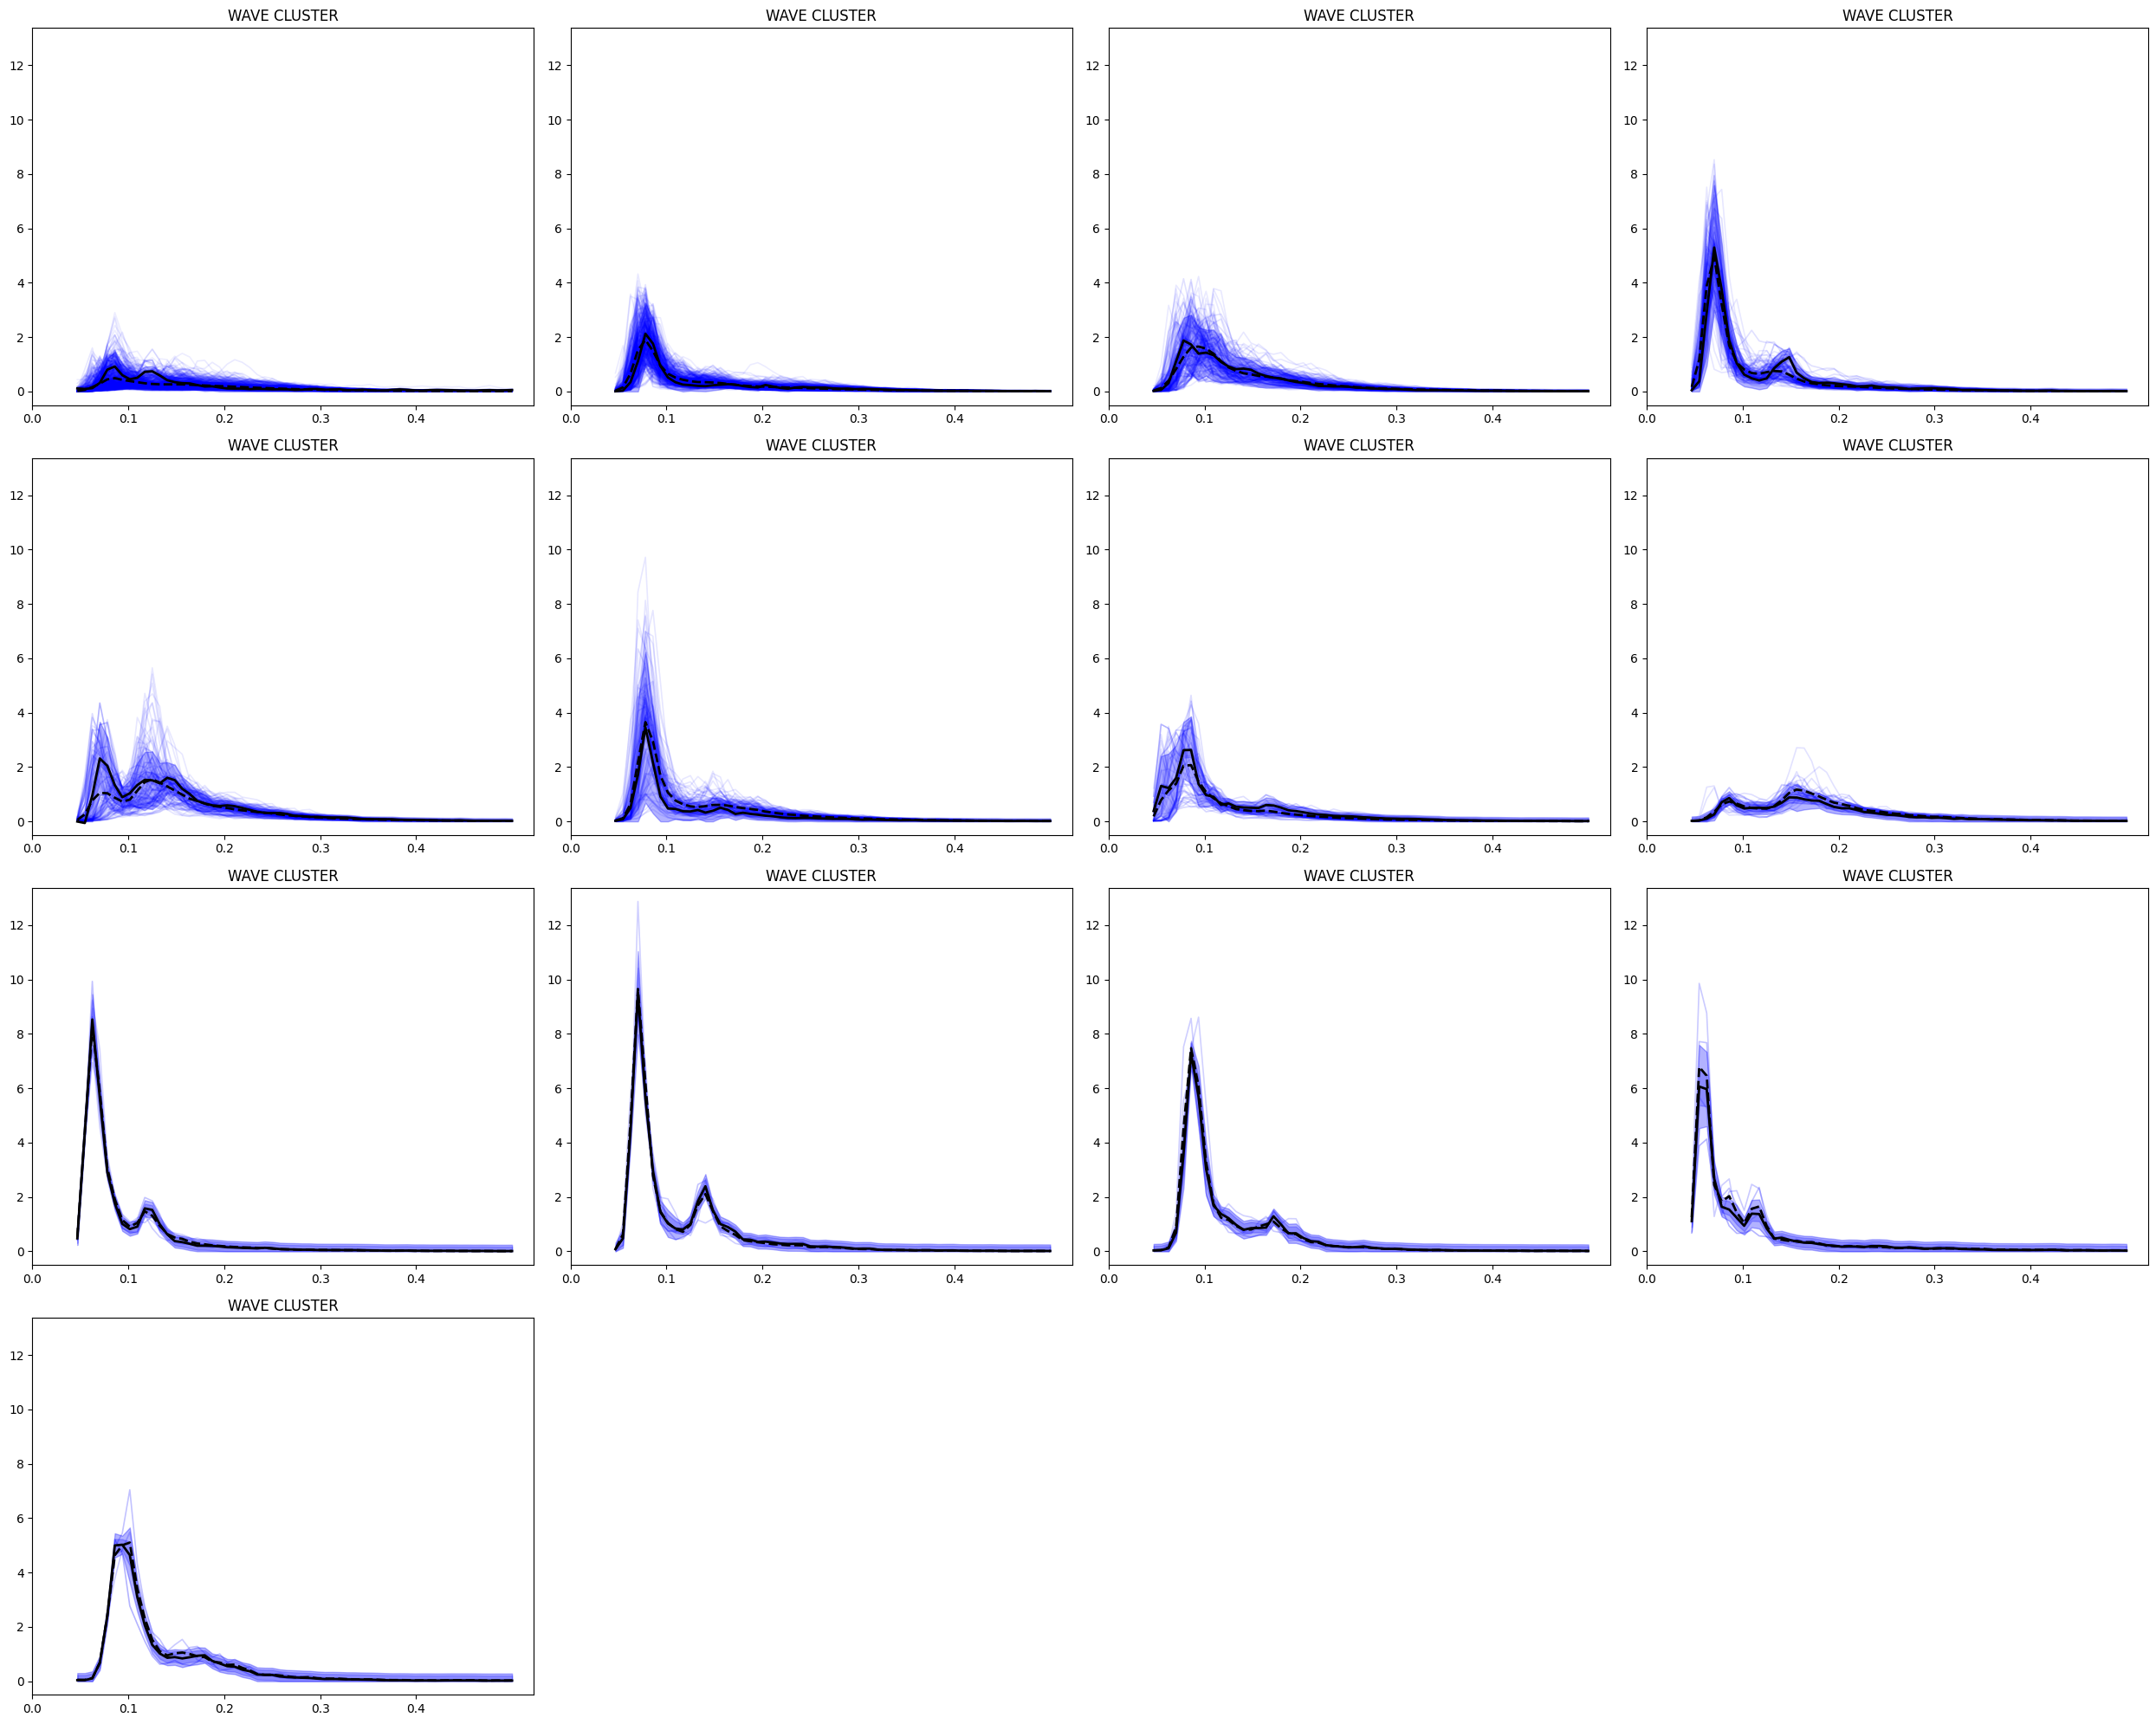

In [45]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Ocean Beach 14

Model 1 : MainModel: N : [N-802]
Model 2 : MainModel: N : [N-246]
Model 3 : MainModel: N : [N-233]
Model 4 : MainModel: N : [N-118]
Model 5 : MainModel: N : [N-41]
Model 6 : MainModel: N : [N-27]
Model 7 : MainModel: N : [N-14]
Model 8 : MainModel: N : [N-9]
Model 9 : MainModel: N : [N-6]
Model 10 : MainModel: N : [N-6]
Model 11 : MainModel: N : [N-6]
Model 12 : MainModel: N : [N-3]
Model 13 : MainModel: N : [N-1]
Model 14 : MainModel: N : [N-1]
Classification error:  0.0 / 1513 -- 0.0


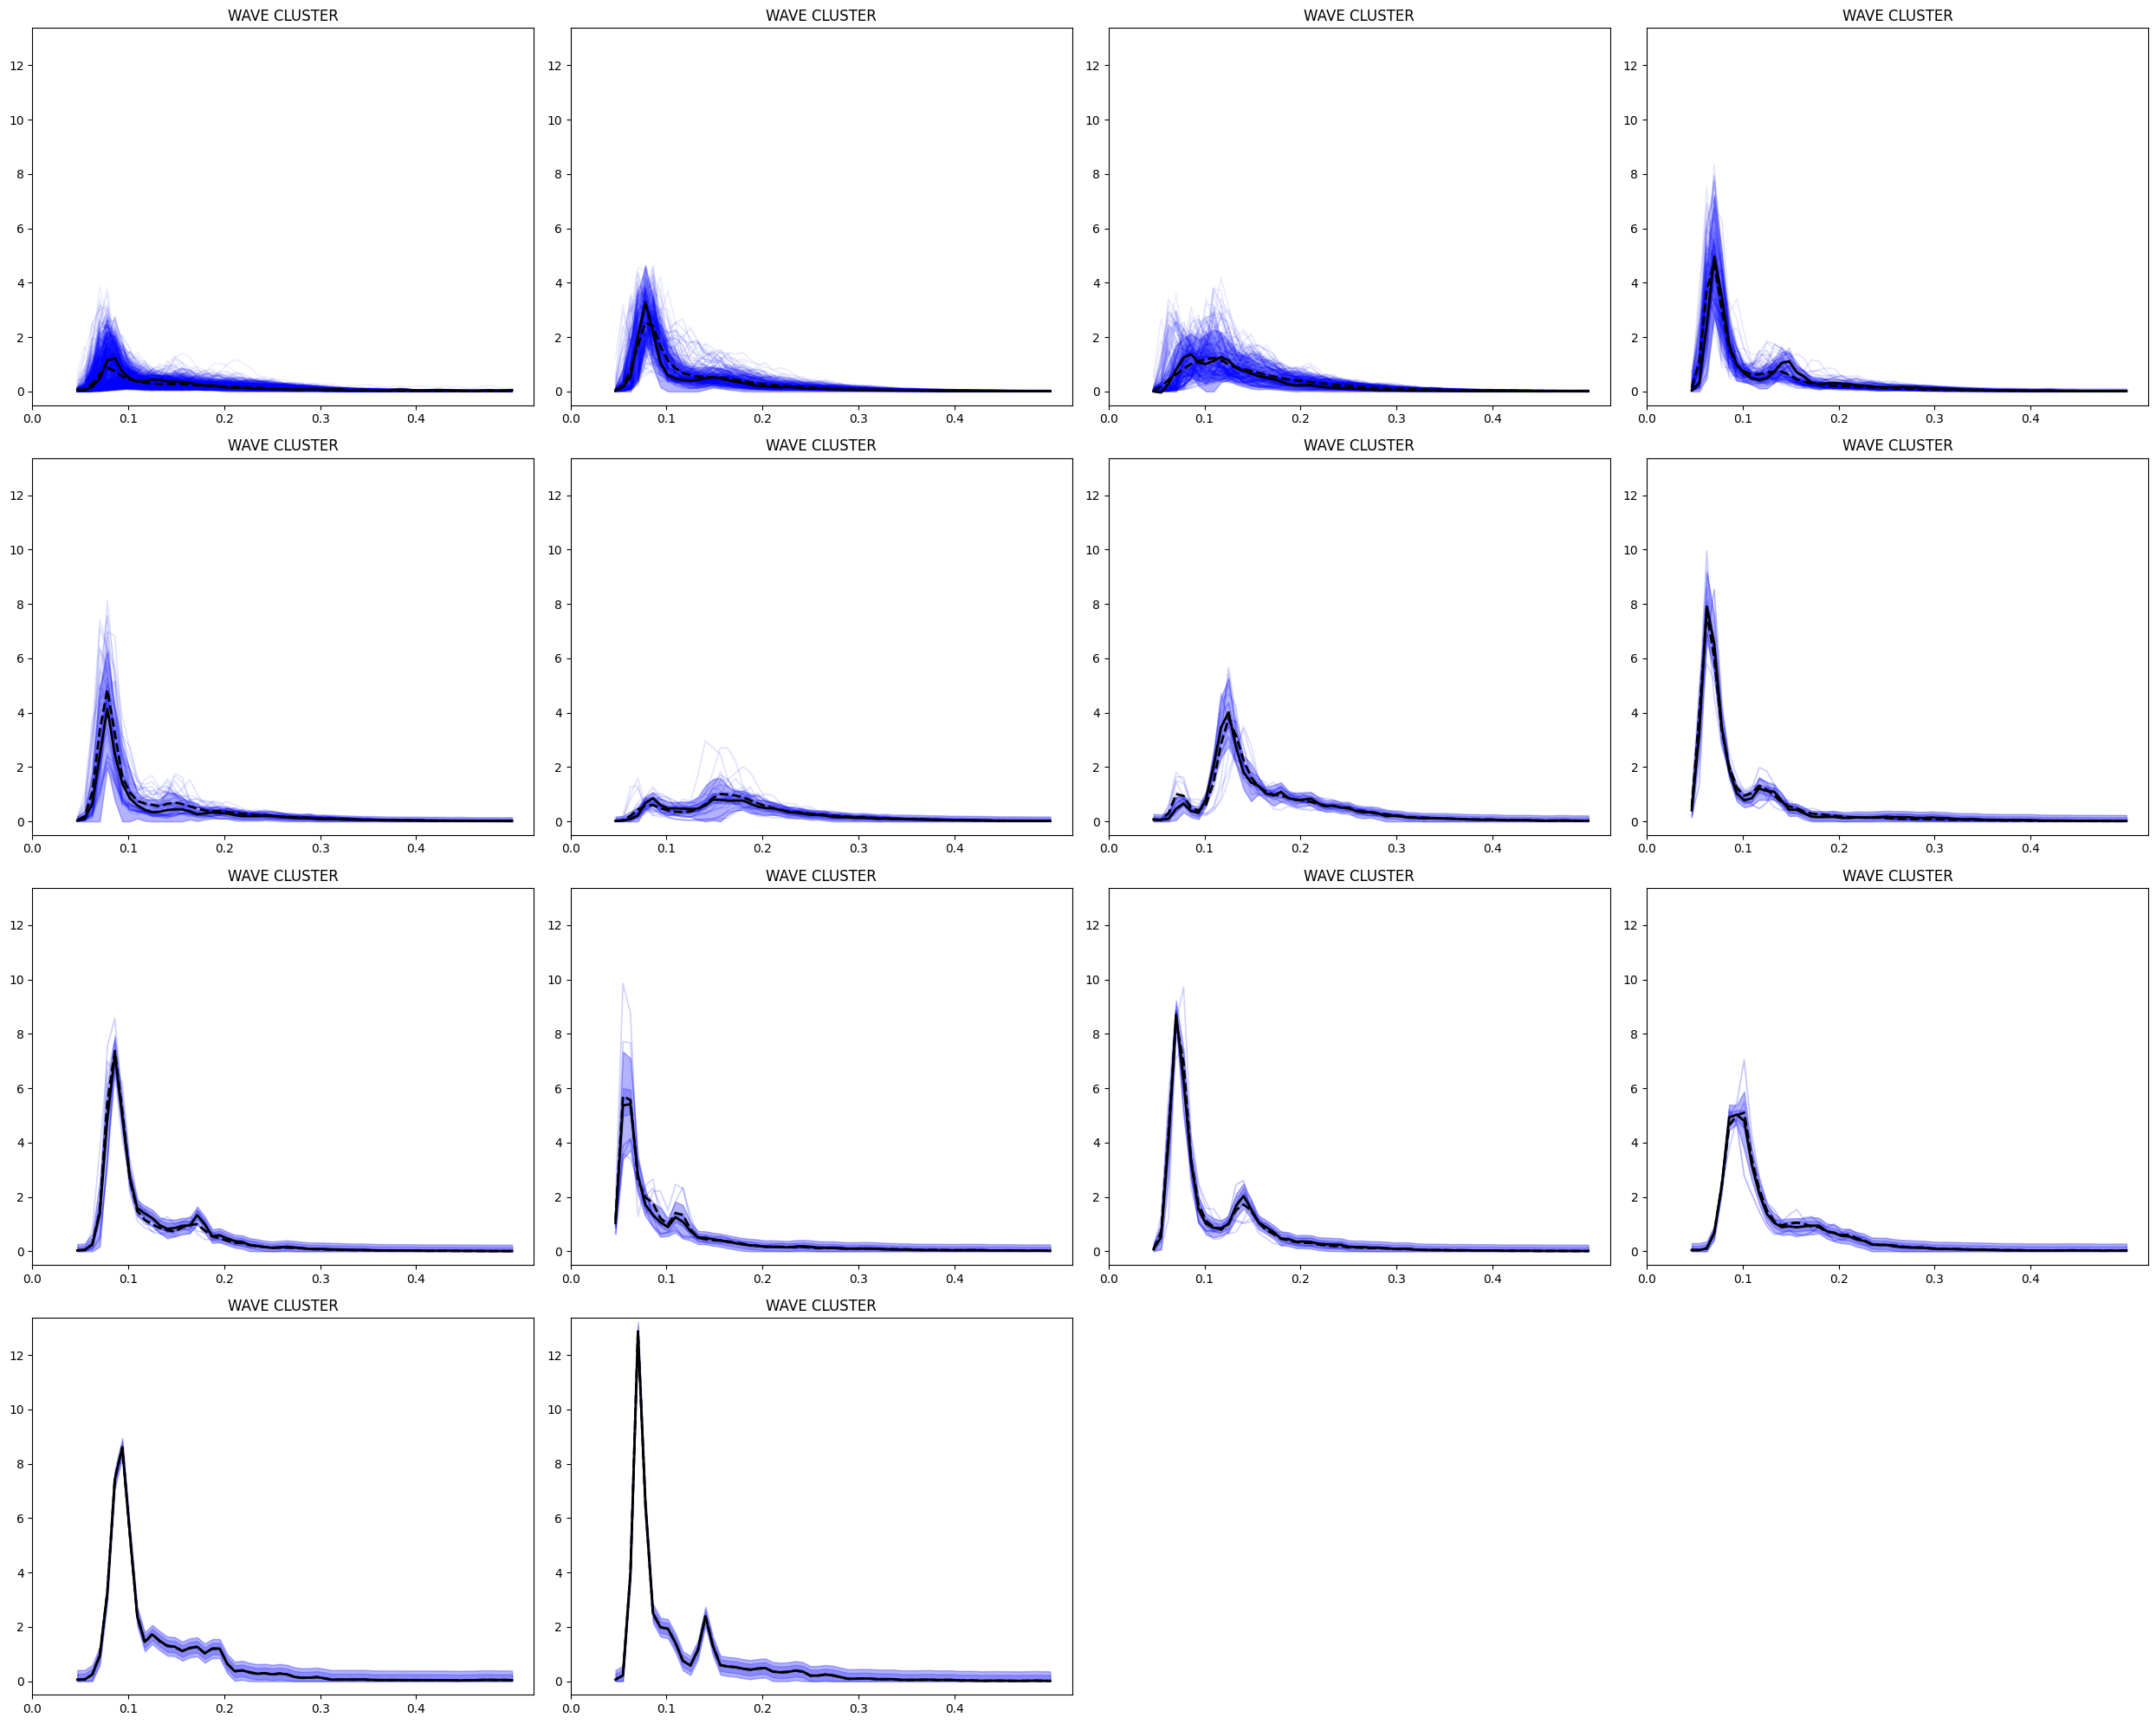

In [32]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Ocean Beach 16 Log

Model 1 : MainModel: N : [N-322]
Model 2 : MainModel: N : [N-210]
Model 3 : MainModel: N : [N-136]
Model 4 : MainModel: N : [N-137]
Model 5 : MainModel: N : [N-109]
Model 6 : MainModel: N : [N-108]
Model 7 : MainModel: N : [N-100]
Model 8 : MainModel: N : [N-92]
Model 9 : MainModel: N : [N-91]
Model 10 : MainModel: N : [N-72]
Model 11 : MainModel: N : [N-69]
Model 12 : MainModel: N : [N-29]
Model 13 : MainModel: N : [N-21]
Model 14 : MainModel: N : [N-16]
Model 15 : MainModel: N : [N-1]
Model 16  : []
Classification error:  0.0 / 1513 -- 0.0


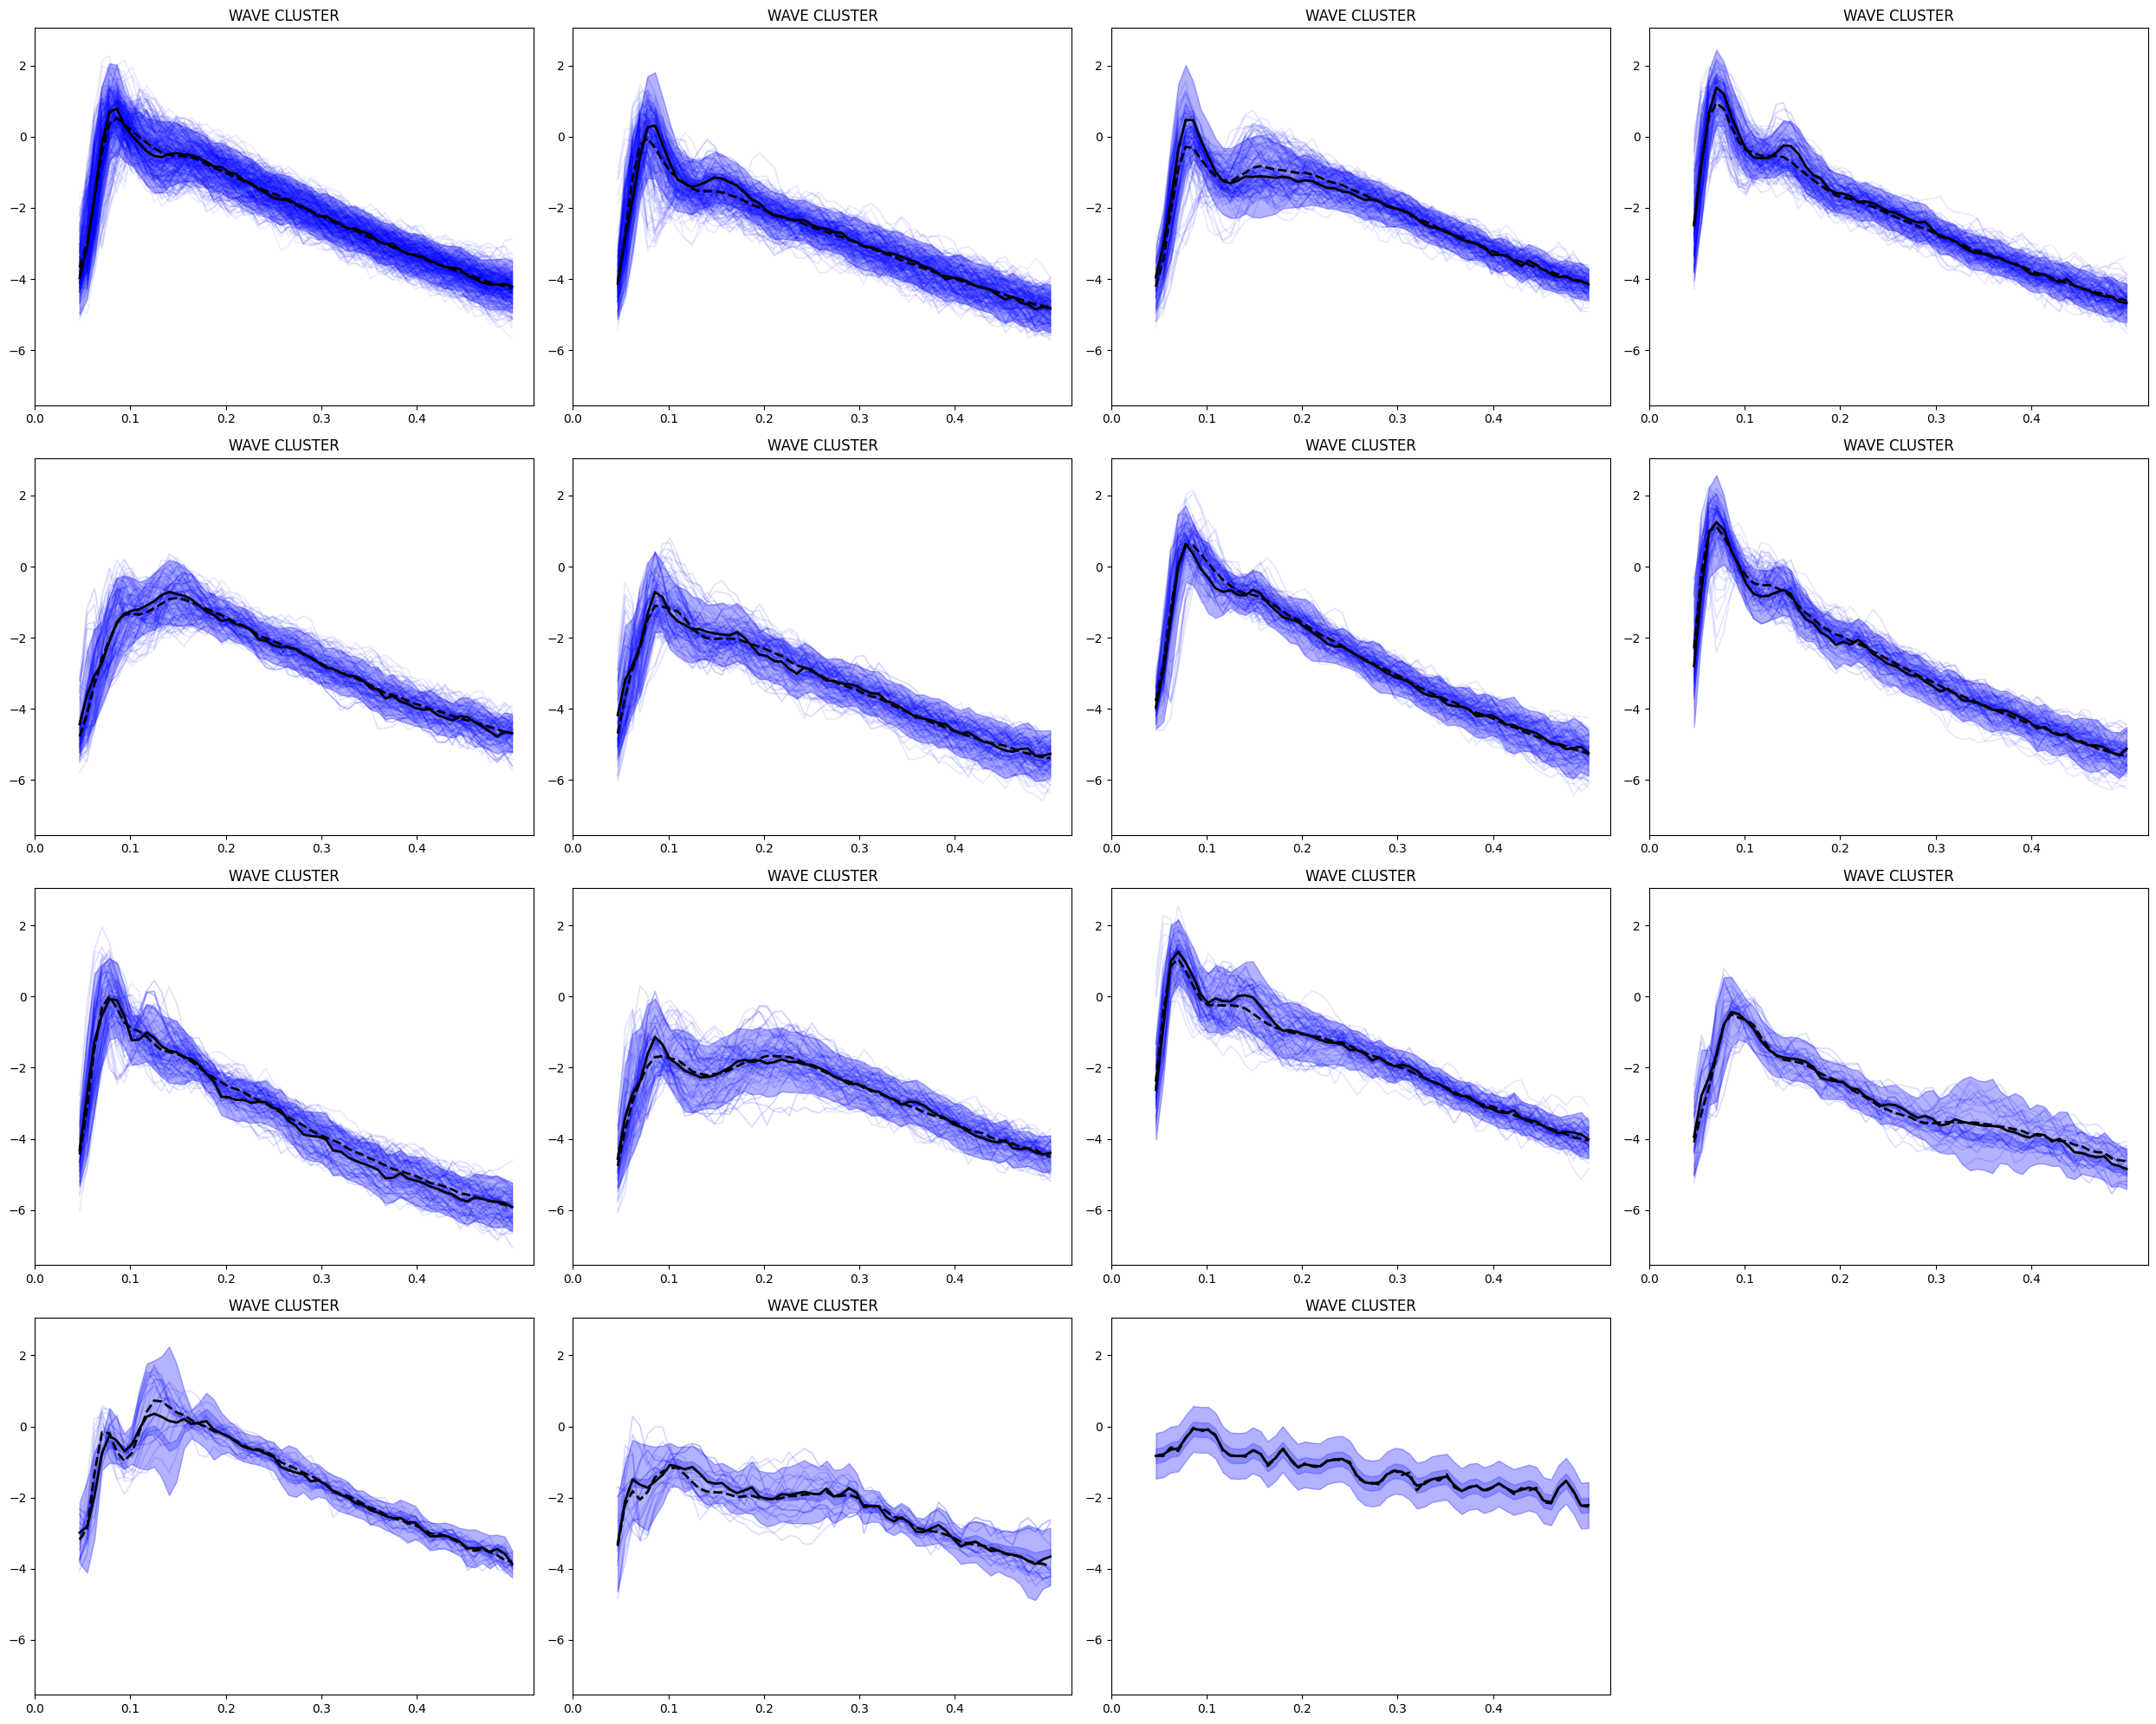

In [18]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

In [49]:
from matplotlib.colors import to_hex
color = {0: 'k', 1: 'b', 2: 'r', 3: 'g', 4: 'c', 5: 'purple', 6: 'darkgreen', 7: 'maroon',
         8: 'orange', 9: 'lightgreen', 10: 'magenta', 11: 'lightblue', 12: 'darkblue', 13: 'red',
         14: 'red', 15: 'goldenrod', 16: 'red'}
labels_trans = {'N': 1, 'V': 2, 'R': 3, '!': 4, 'F': 5, 'L': 6, 'A': 7, '/': 8, 'Q': 9, 'f': 10, 'E': 11,
                'J': 12, 'j': 13, 'e': 14, 'a': 15, 'S': 16}
def plot_models_plotly_log(sw_gp, selected_gpmodels, main_model, labels, N_0, title=None, save=None, lead=0, step=0.1, plot_latent=False, ticks=False, yscale=False):
    num_models = len(selected_gpmodels)
    num_cols = int(np.ceil(np.sqrt(num_models)))
    num_rows = int(np.ceil(num_models / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
    axes = axes.flatten()

    def col_fun(lab):
        if type(labels[0]) is np.int32:
            return to_hex(color.get(lab, 'b'))
        else:
            return to_hex(color.get(labels_trans.get(lab, 0), 'b'))

    for i, m in enumerate(selected_gpmodels):
        ax = axes[i]
        gp = sw_gp.gpmodels[lead][m]

        # Plot training data
        for j_, d in enumerate(gp.y_train):
            j = gp.indexes[j_]
            x_t = gp.x_train[j_].T[0]
            d = np.exp(sw_gp.y_train[j,:,[lead]] - 1e-6)
            if isinstance(d, torch.Tensor):
                d = d.detach().cpu()
                x_t = x_t.cpu() 
            ax.plot(x_t, d.T[0], alpha=max(0.07, 0.5 / (np.log(len(gp.y_train) - j_ + 1) + 1)),
                    color=col_fun(labels[j + N_0]), linewidth=1.2)

        # Mean and variance
        x_b = gp.x_basis.T[0]
        if (x_b[1] - x_b[0]) == step:
            x_ = torch.clone(x_b)
        else:
            x_ = torch.arange(min(x_b), max(x_b), step, dtype=torch.float64).cpu()

        mean_, Sig_ = gp.observe_last(torch.atleast_2d(x_).T)
        #mean_l, Sig_l = gp.step_forward_last(torch.atleast_2d(x_).T)

        noise_ob = np.sqrt(np.diag(Sig_.cpu()))
        mean = np.exp(mean_.cpu().T[0] - 1e-6)
        neg_lim = mean - 1.9 * noise_ob
        neg_lim[neg_lim < 0.0] = 0.0
        ax.plot(x_, mean, color='black', linewidth=2, label=f'Emission GP mean [{m + 1}]')
        ax.fill_between(x_, neg_lim - 1e-6, mean + 1.9 * noise_ob, color=col_fun(main_model[i]), alpha=0.3)

        # Latent mean
        mean_latent = np.exp(gp.f_star_sm[-1].cpu().T[0])
        noise_lat = 1.9 * np.sqrt(np.diag(gp.Gamma[-1].cpu()))
        neg_lim = mean_latent - noise_lat
        neg_lim[neg_lim < 0.0] = 0.0
        # ax.plot(x_b.cpu(), mean_latent, color='grey', linewidth=1.5, label=f'Latent GP Mean [{m + 1}]')
        ax.fill_between(x_b.cpu(), neg_lim - 1e-6, mean_latent+noise_lat, color=col_fun(main_model[i]), alpha=0.22)

        #Experimental mean
        mean = np.exp(np.mean(np.array(gp.y_train), axis=0))
        ax.plot(x_b.cpu(), mean - 1e-6, color='black', linewidth=2, label=f'Experimental mean [{m + 1}]', linestyle='--')

        if title is None:
            ax.set_title(f"ECG CLUSTER {m + 1} ({main_model[m]})")
        else:
            ax.set_title(title)
        #ax.grid(True)
    if yscale:
        for ax in fig.get_axes():
            ax.set_ylim(np.min(np.exp(sw_gp.y_train.numpy() - 1e-6))-0.5, np.max(np.exp(sw_gp.y_train.numpy() - 1e-6)) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))
    if not ticks:
        for ax in fig.get_axes():
        #     ax.label_outer()
        #     ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
        #     ax.set_yticks([])
    # Hide unused subplots
    for j in range(len(axes)):
        if j >= num_models:
            axes[j].axis('off')

    fig.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

Model 1 : MainModel: N : [N-322]
Model 2 : MainModel: N : [N-210]
Model 3 : MainModel: N : [N-136]
Model 4 : MainModel: N : [N-137]
Model 5 : MainModel: N : [N-109]
Model 6 : MainModel: N : [N-108]
Model 7 : MainModel: N : [N-100]
Model 8 : MainModel: N : [N-92]
Model 9 : MainModel: N : [N-91]
Model 10 : MainModel: N : [N-72]
Model 11 : MainModel: N : [N-69]
Model 12 : MainModel: N : [N-29]
Model 13 : MainModel: N : [N-21]
Model 14 : MainModel: N : [N-16]
Model 15 : MainModel: N : [N-1]
Model 16  : []
Classification error:  0.0 / 1513 -- 0.0


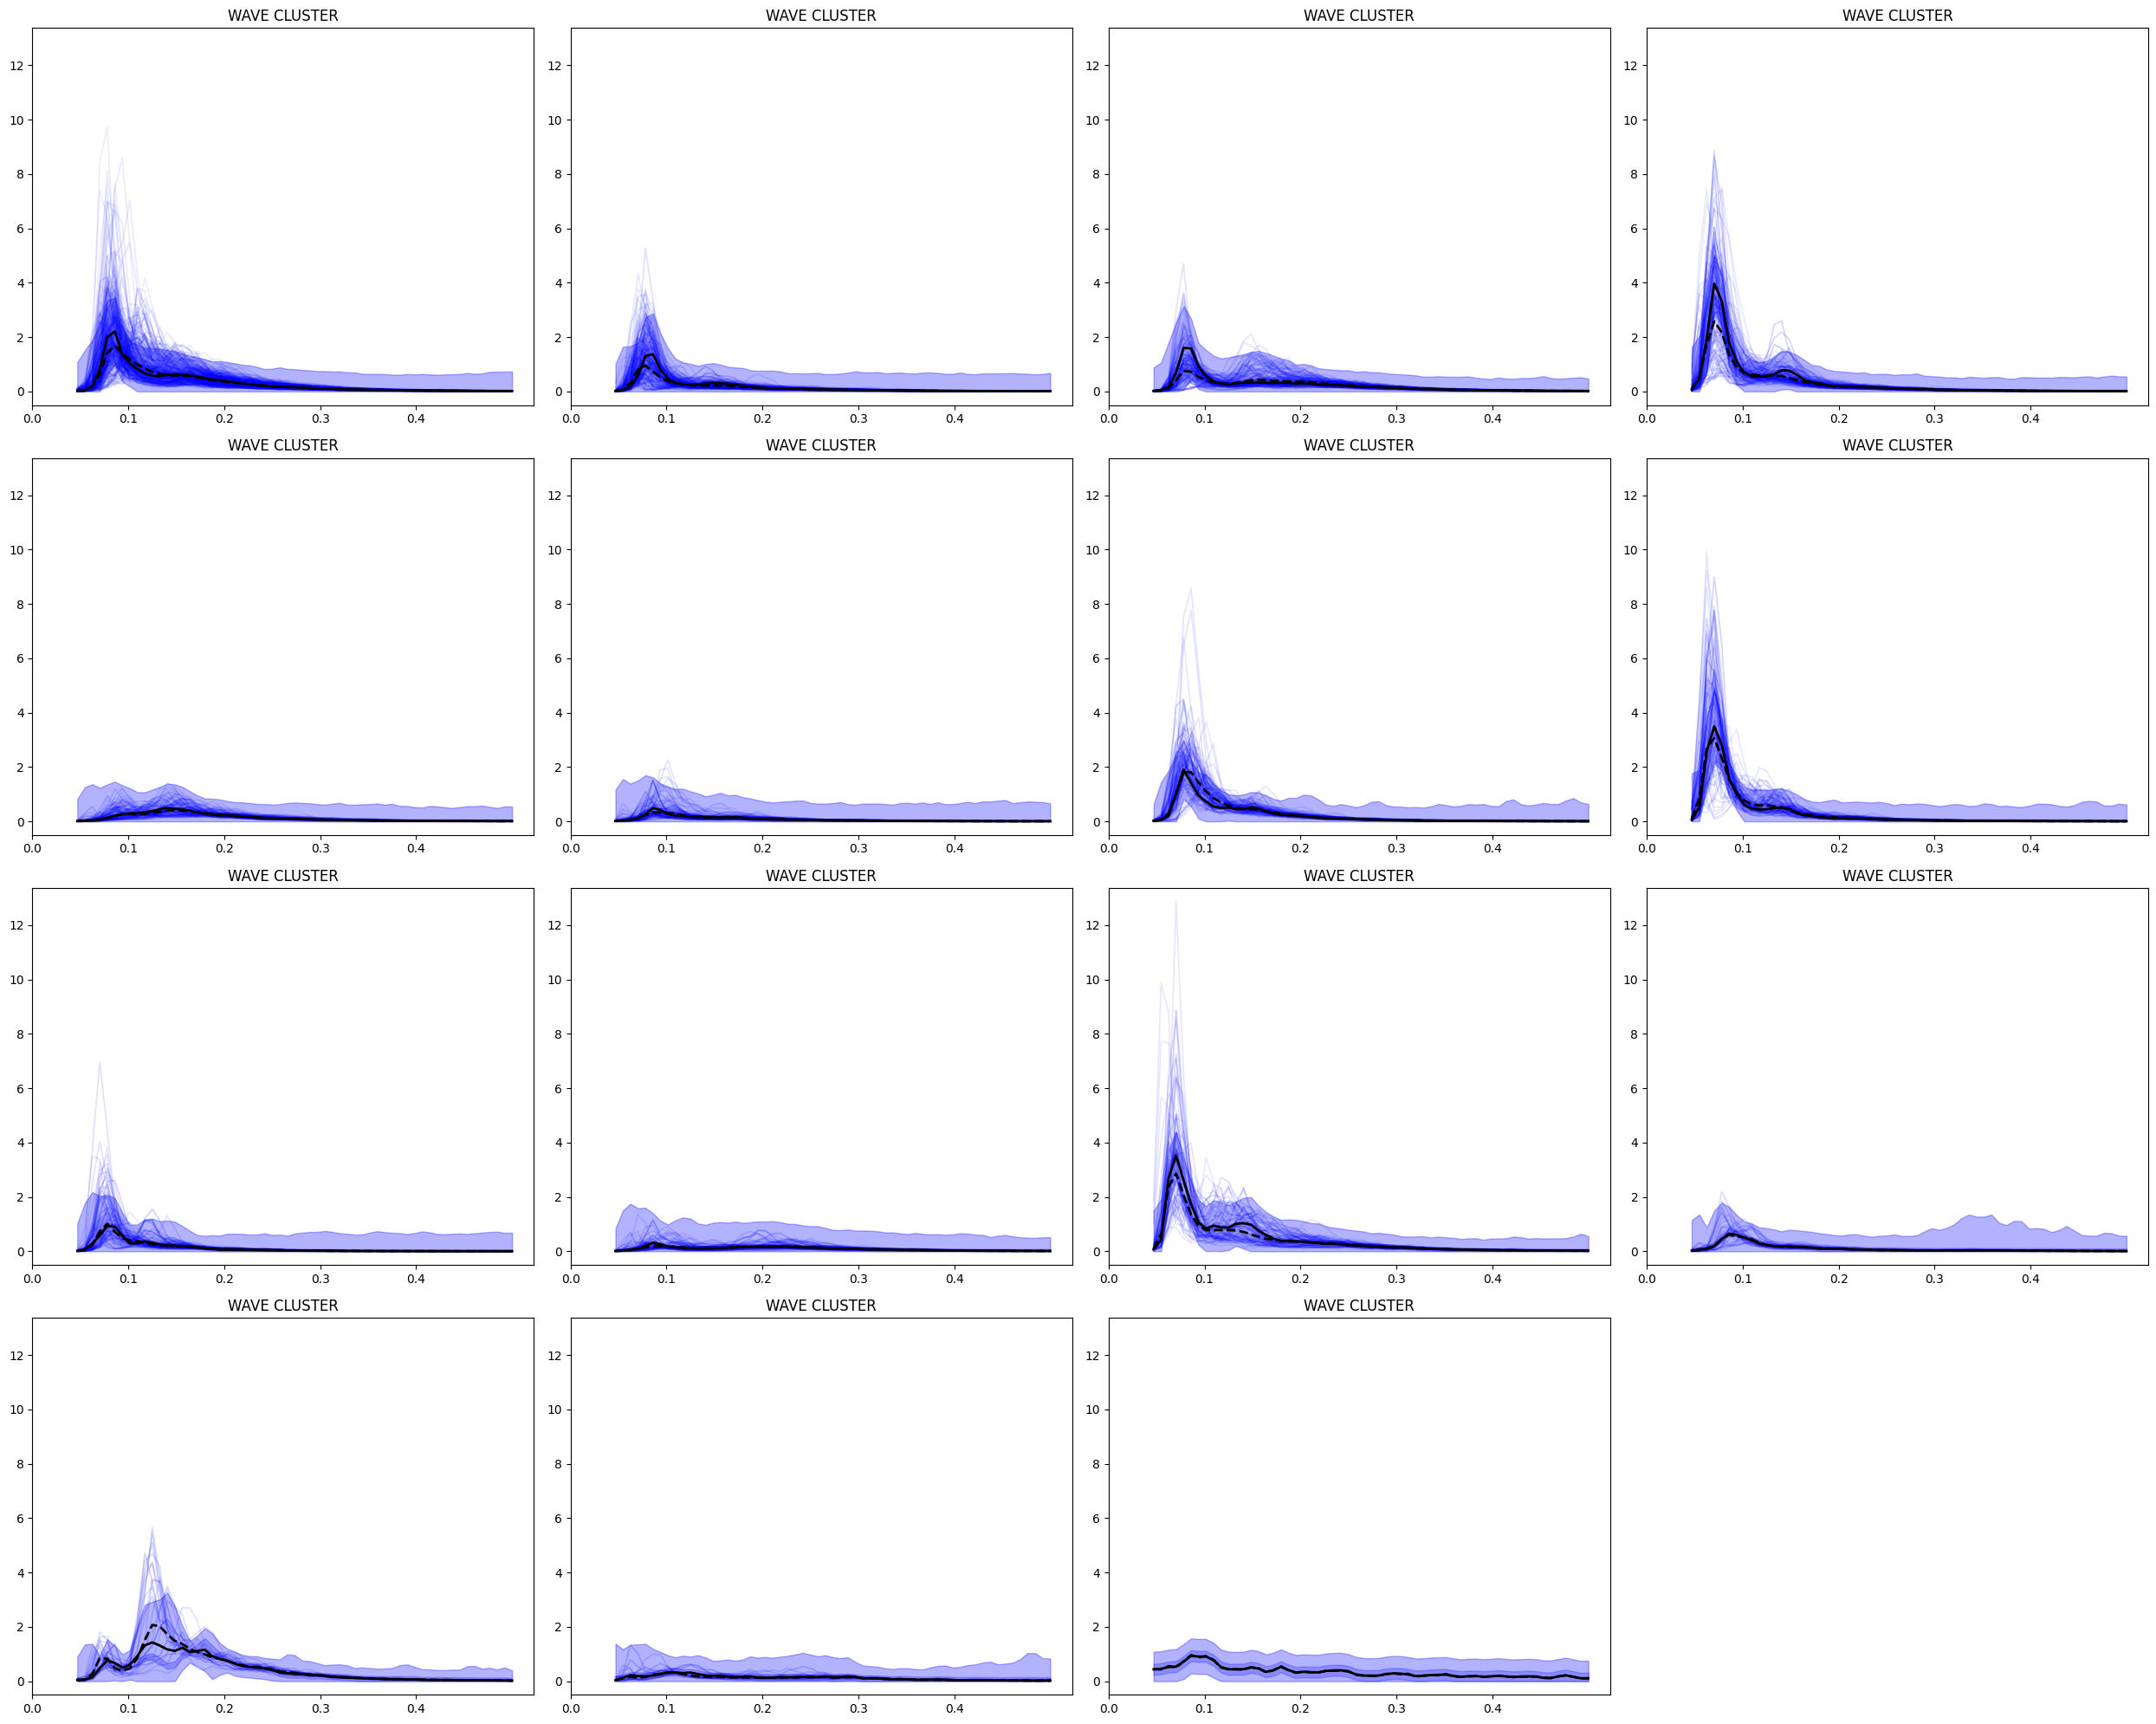

In [50]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly_log(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Torbay 13

Model 1 : MainModel: N : [N-475]
Model 2 : MainModel: N : [N-196]
Model 3 : MainModel: N : [N-98]
Model 4 : MainModel: N : [N-90]
Model 5 : MainModel: N : [N-71]
Model 6 : MainModel: N : [N-56]
Model 7 : MainModel: N : [N-49]
Model 8 : MainModel: N : [N-31]
Model 9 : MainModel: N : [N-30]
Model 10 : MainModel: N : [N-30]
Model 11 : MainModel: N : [N-19]
Model 12 : MainModel: N : [N-13]
Model 13 : MainModel: N : [N-8]
Model 14  : []
Classification error:  0.0 / 1166 -- 0.0


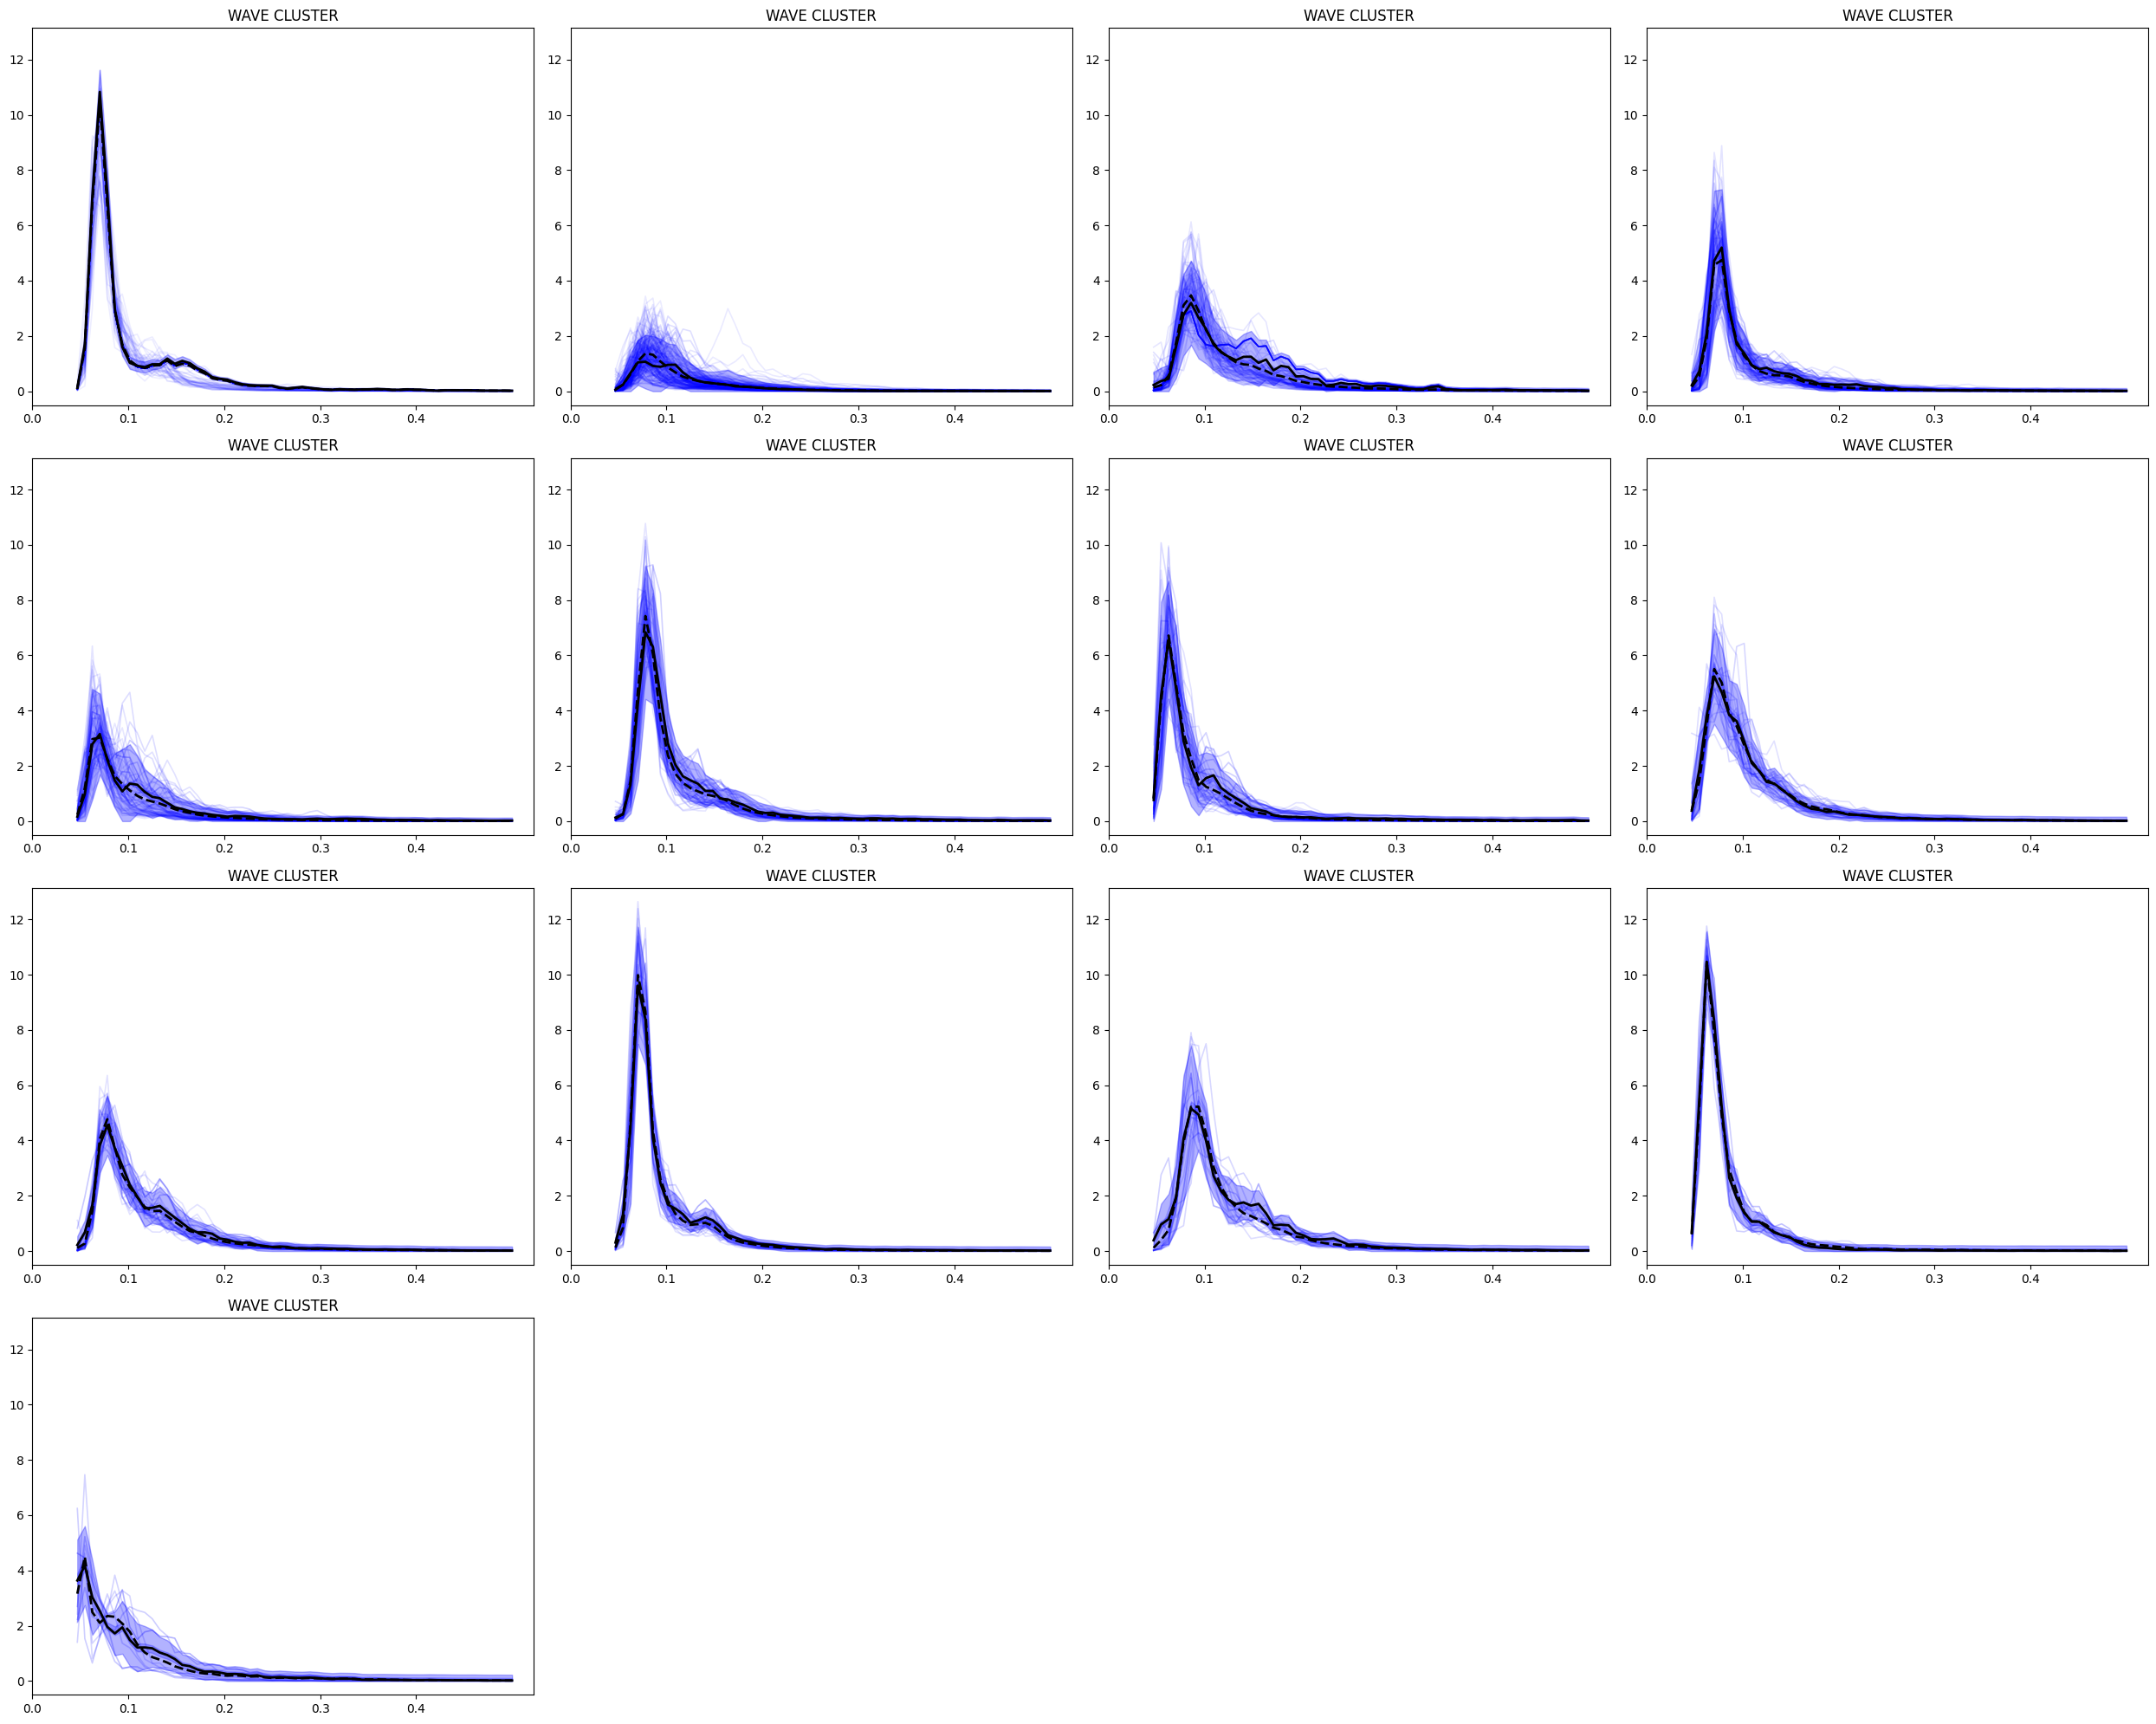

In [27]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

#### Torbay 17 clusters

Model 1 : MainModel: N : [N-456]
Model 2 : MainModel: N : [N-195]
Model 3 : MainModel: N : [N-117]
Model 4 : MainModel: N : [N-90]
Model 5 : MainModel: N : [N-69]
Model 6 : MainModel: N : [N-43]
Model 7 : MainModel: N : [N-42]
Model 8 : MainModel: N : [N-39]
Model 9 : MainModel: N : [N-25]
Model 10 : MainModel: N : [N-24]
Model 11 : MainModel: N : [N-21]
Model 12 : MainModel: N : [N-15]
Model 13 : MainModel: N : [N-13]
Model 14 : MainModel: N : [N-7]
Model 15 : MainModel: N : [N-5]
Model 16 : MainModel: N : [N-3]
Model 17 : MainModel: N : [N-2]
Classification error:  0.0 / 1166 -- 0.0


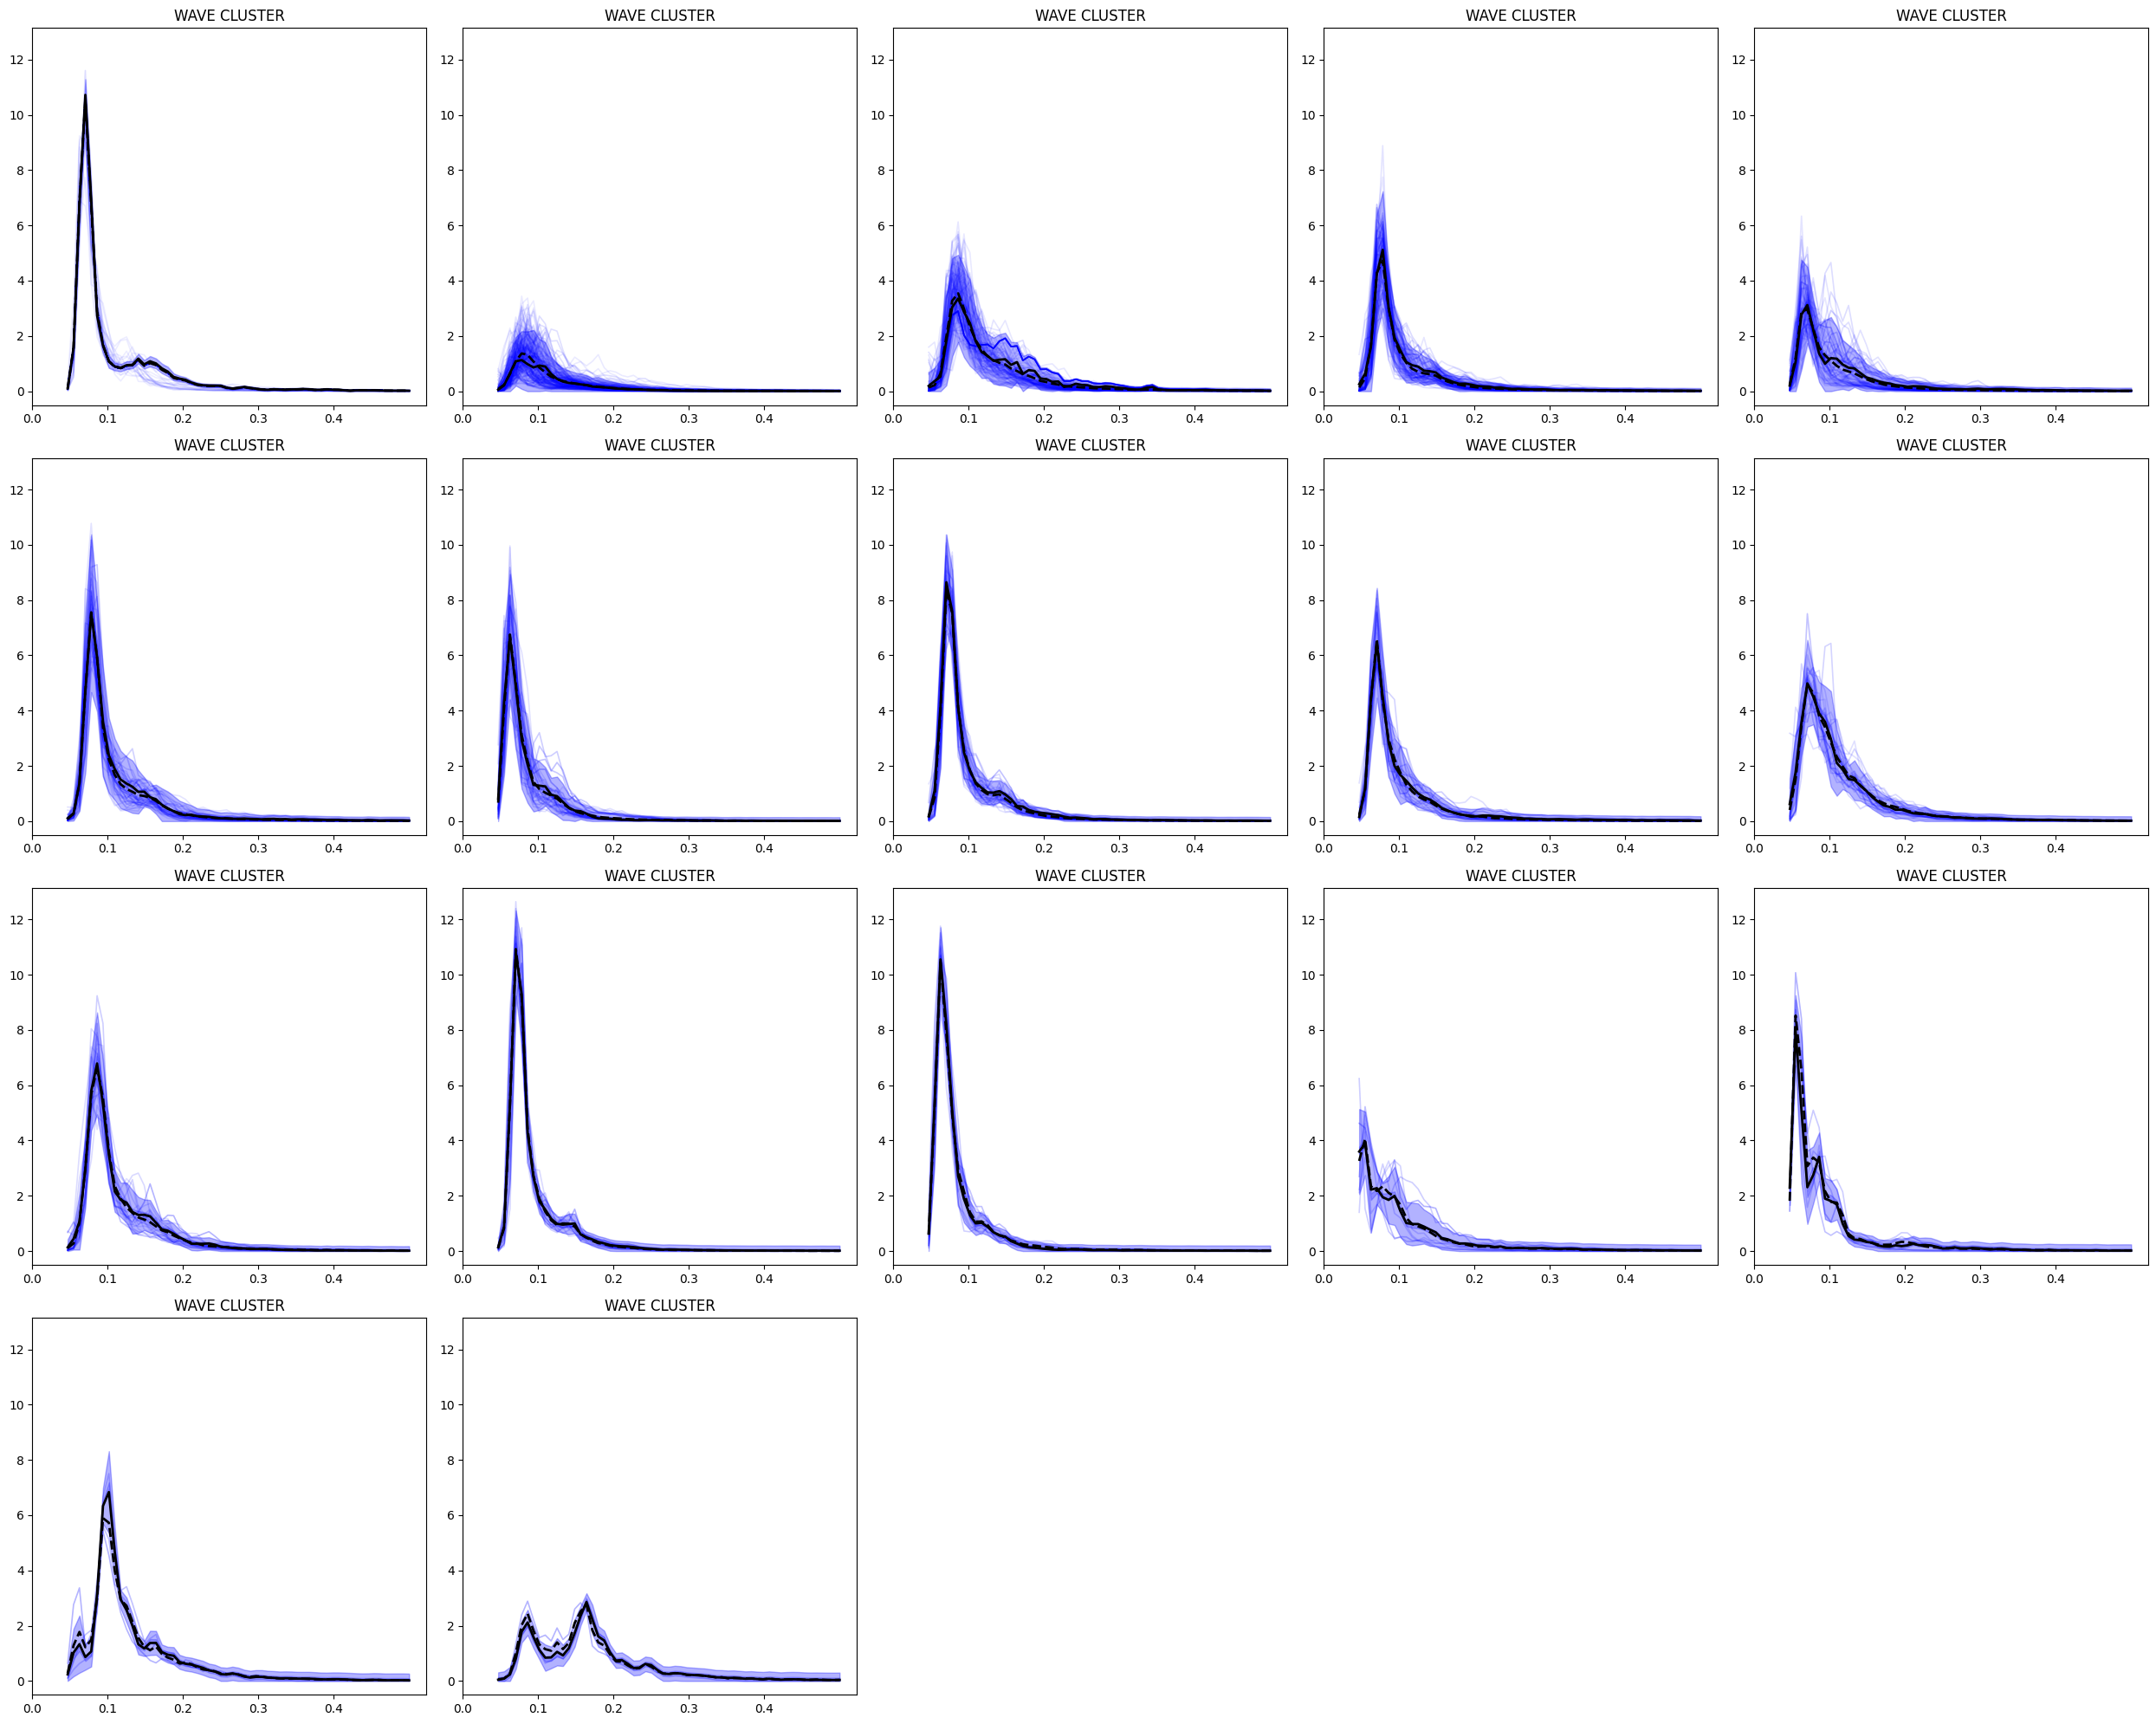

In [41]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

### Torbay 14

Model 1 : MainModel: N : [N-482]
Model 2 : MainModel: N : [N-125]
Model 3 : MainModel: N : [N-92]
Model 4 : MainModel: N : [N-90]
Model 5 : MainModel: N : [N-76]
Model 6 : MainModel: N : [N-65]
Model 7 : MainModel: N : [N-63]
Model 8 : MainModel: N : [N-42]
Model 9 : MainModel: N : [N-40]
Model 10 : MainModel: N : [N-26]
Model 11 : MainModel: N : [N-24]
Model 12 : MainModel: N : [N-19]
Model 13 : MainModel: N : [N-12]
Model 14 : MainModel: N : [N-10]
Classification error:  0.0 / 1166 -- 0.0


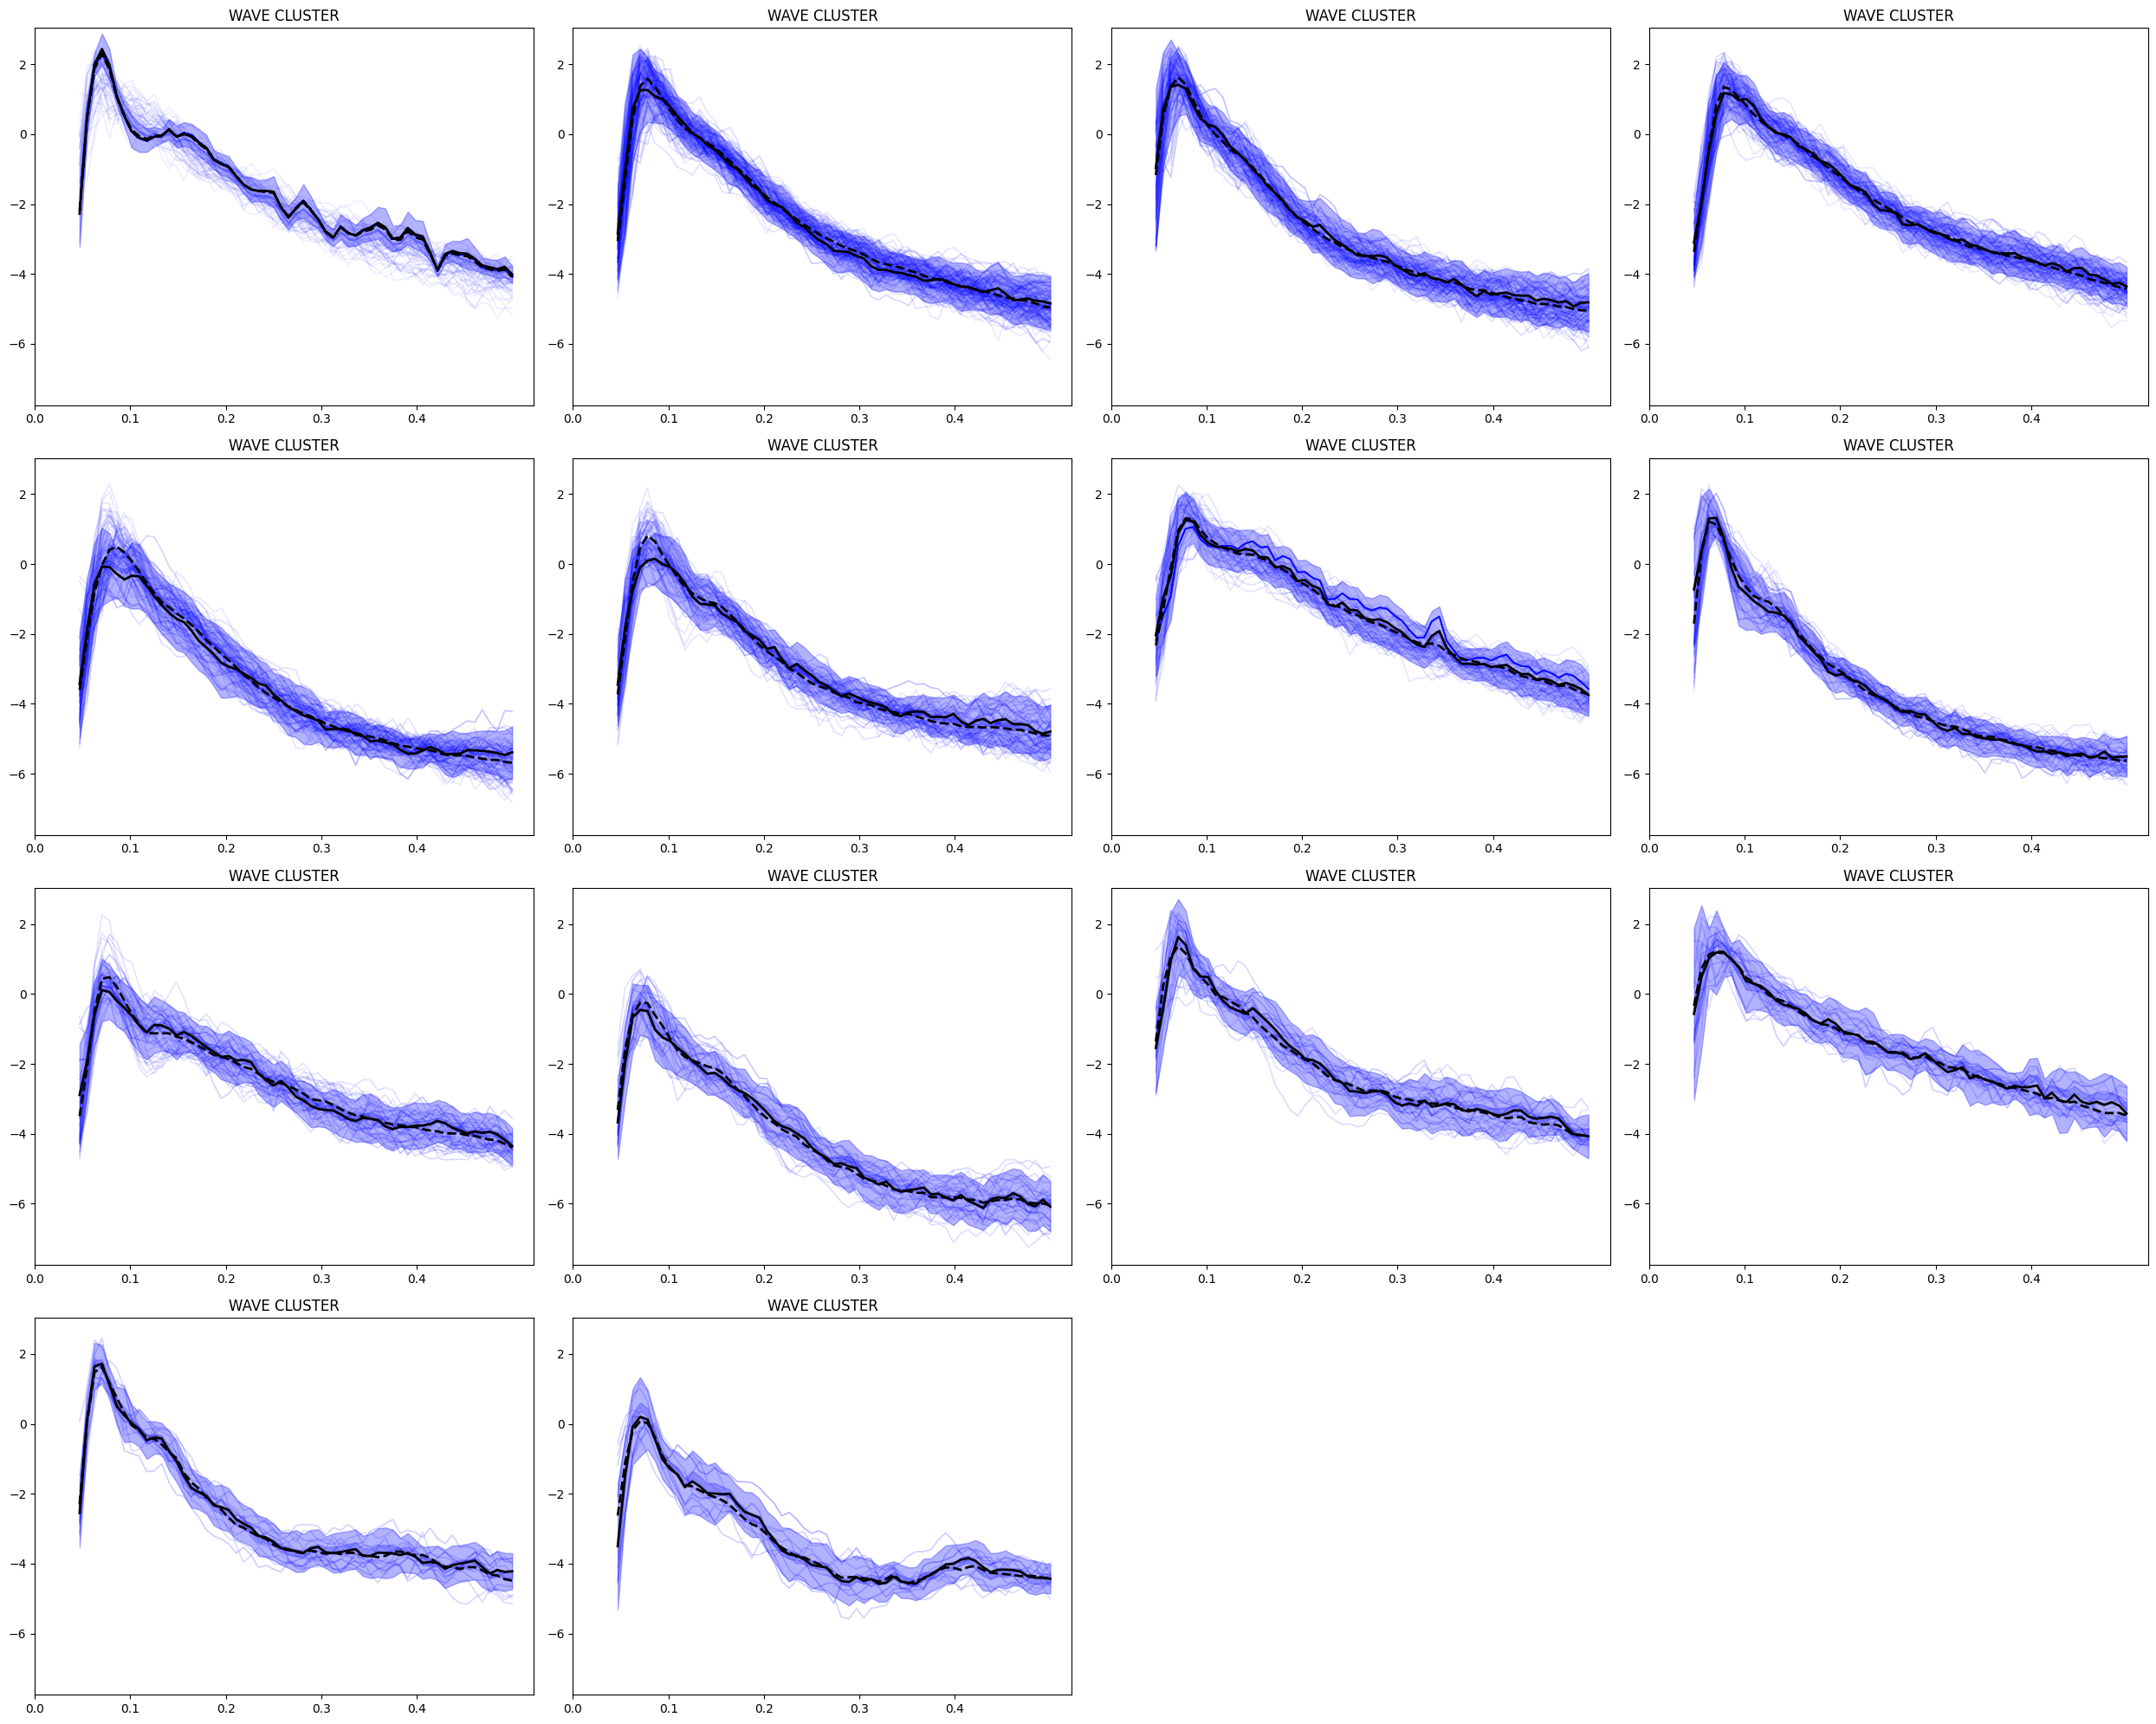

In [121]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

Model 1 : MainModel: N : [N-482]
Model 2 : MainModel: N : [N-125]
Model 3 : MainModel: N : [N-92]
Model 4 : MainModel: N : [N-90]
Model 5 : MainModel: N : [N-76]
Model 6 : MainModel: N : [N-65]
Model 7 : MainModel: N : [N-63]
Model 8 : MainModel: N : [N-42]
Model 9 : MainModel: N : [N-40]
Model 10 : MainModel: N : [N-26]
Model 11 : MainModel: N : [N-24]
Model 12 : MainModel: N : [N-19]
Model 13 : MainModel: N : [N-12]
Model 14 : MainModel: N : [N-10]
Classification error:  0.0 / 1166 -- 0.0


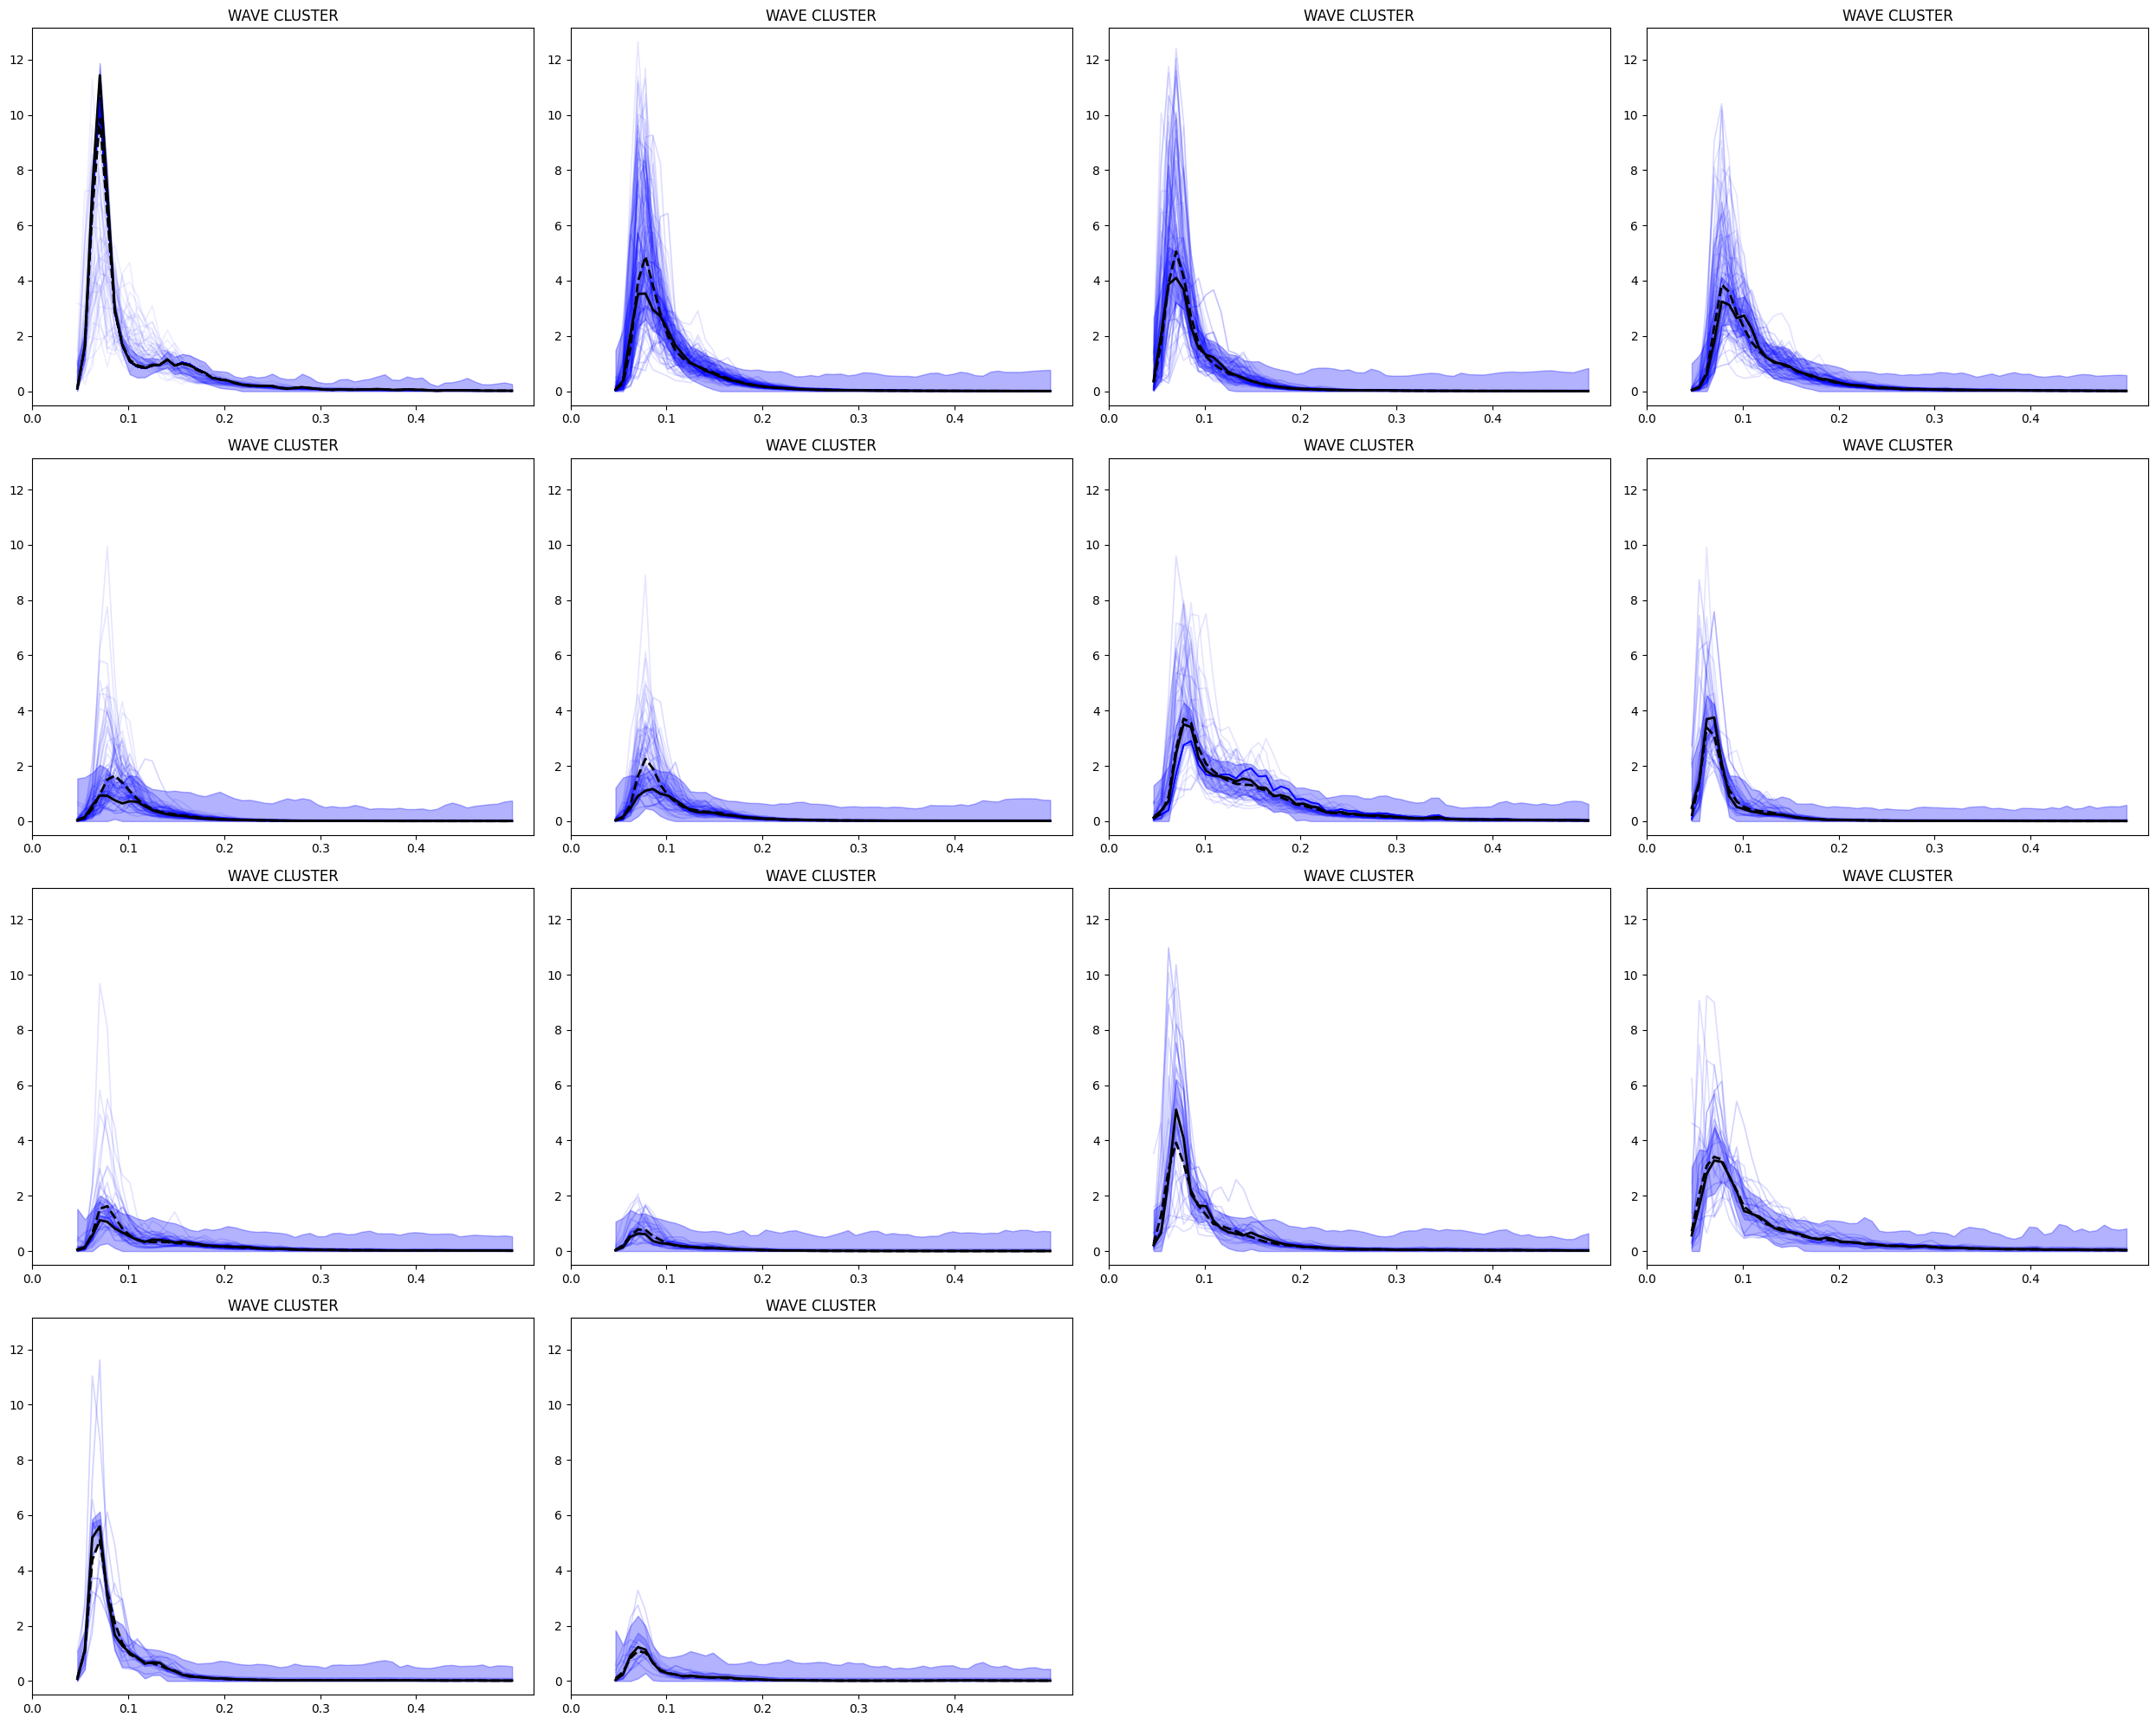

In [122]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly_log(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True)

### Clasificación con CLARA

In [70]:
data_df = pd.DataFrame(np.squeeze(data[:, 0:len(freq), :], axis=-1))

### 10 clusters

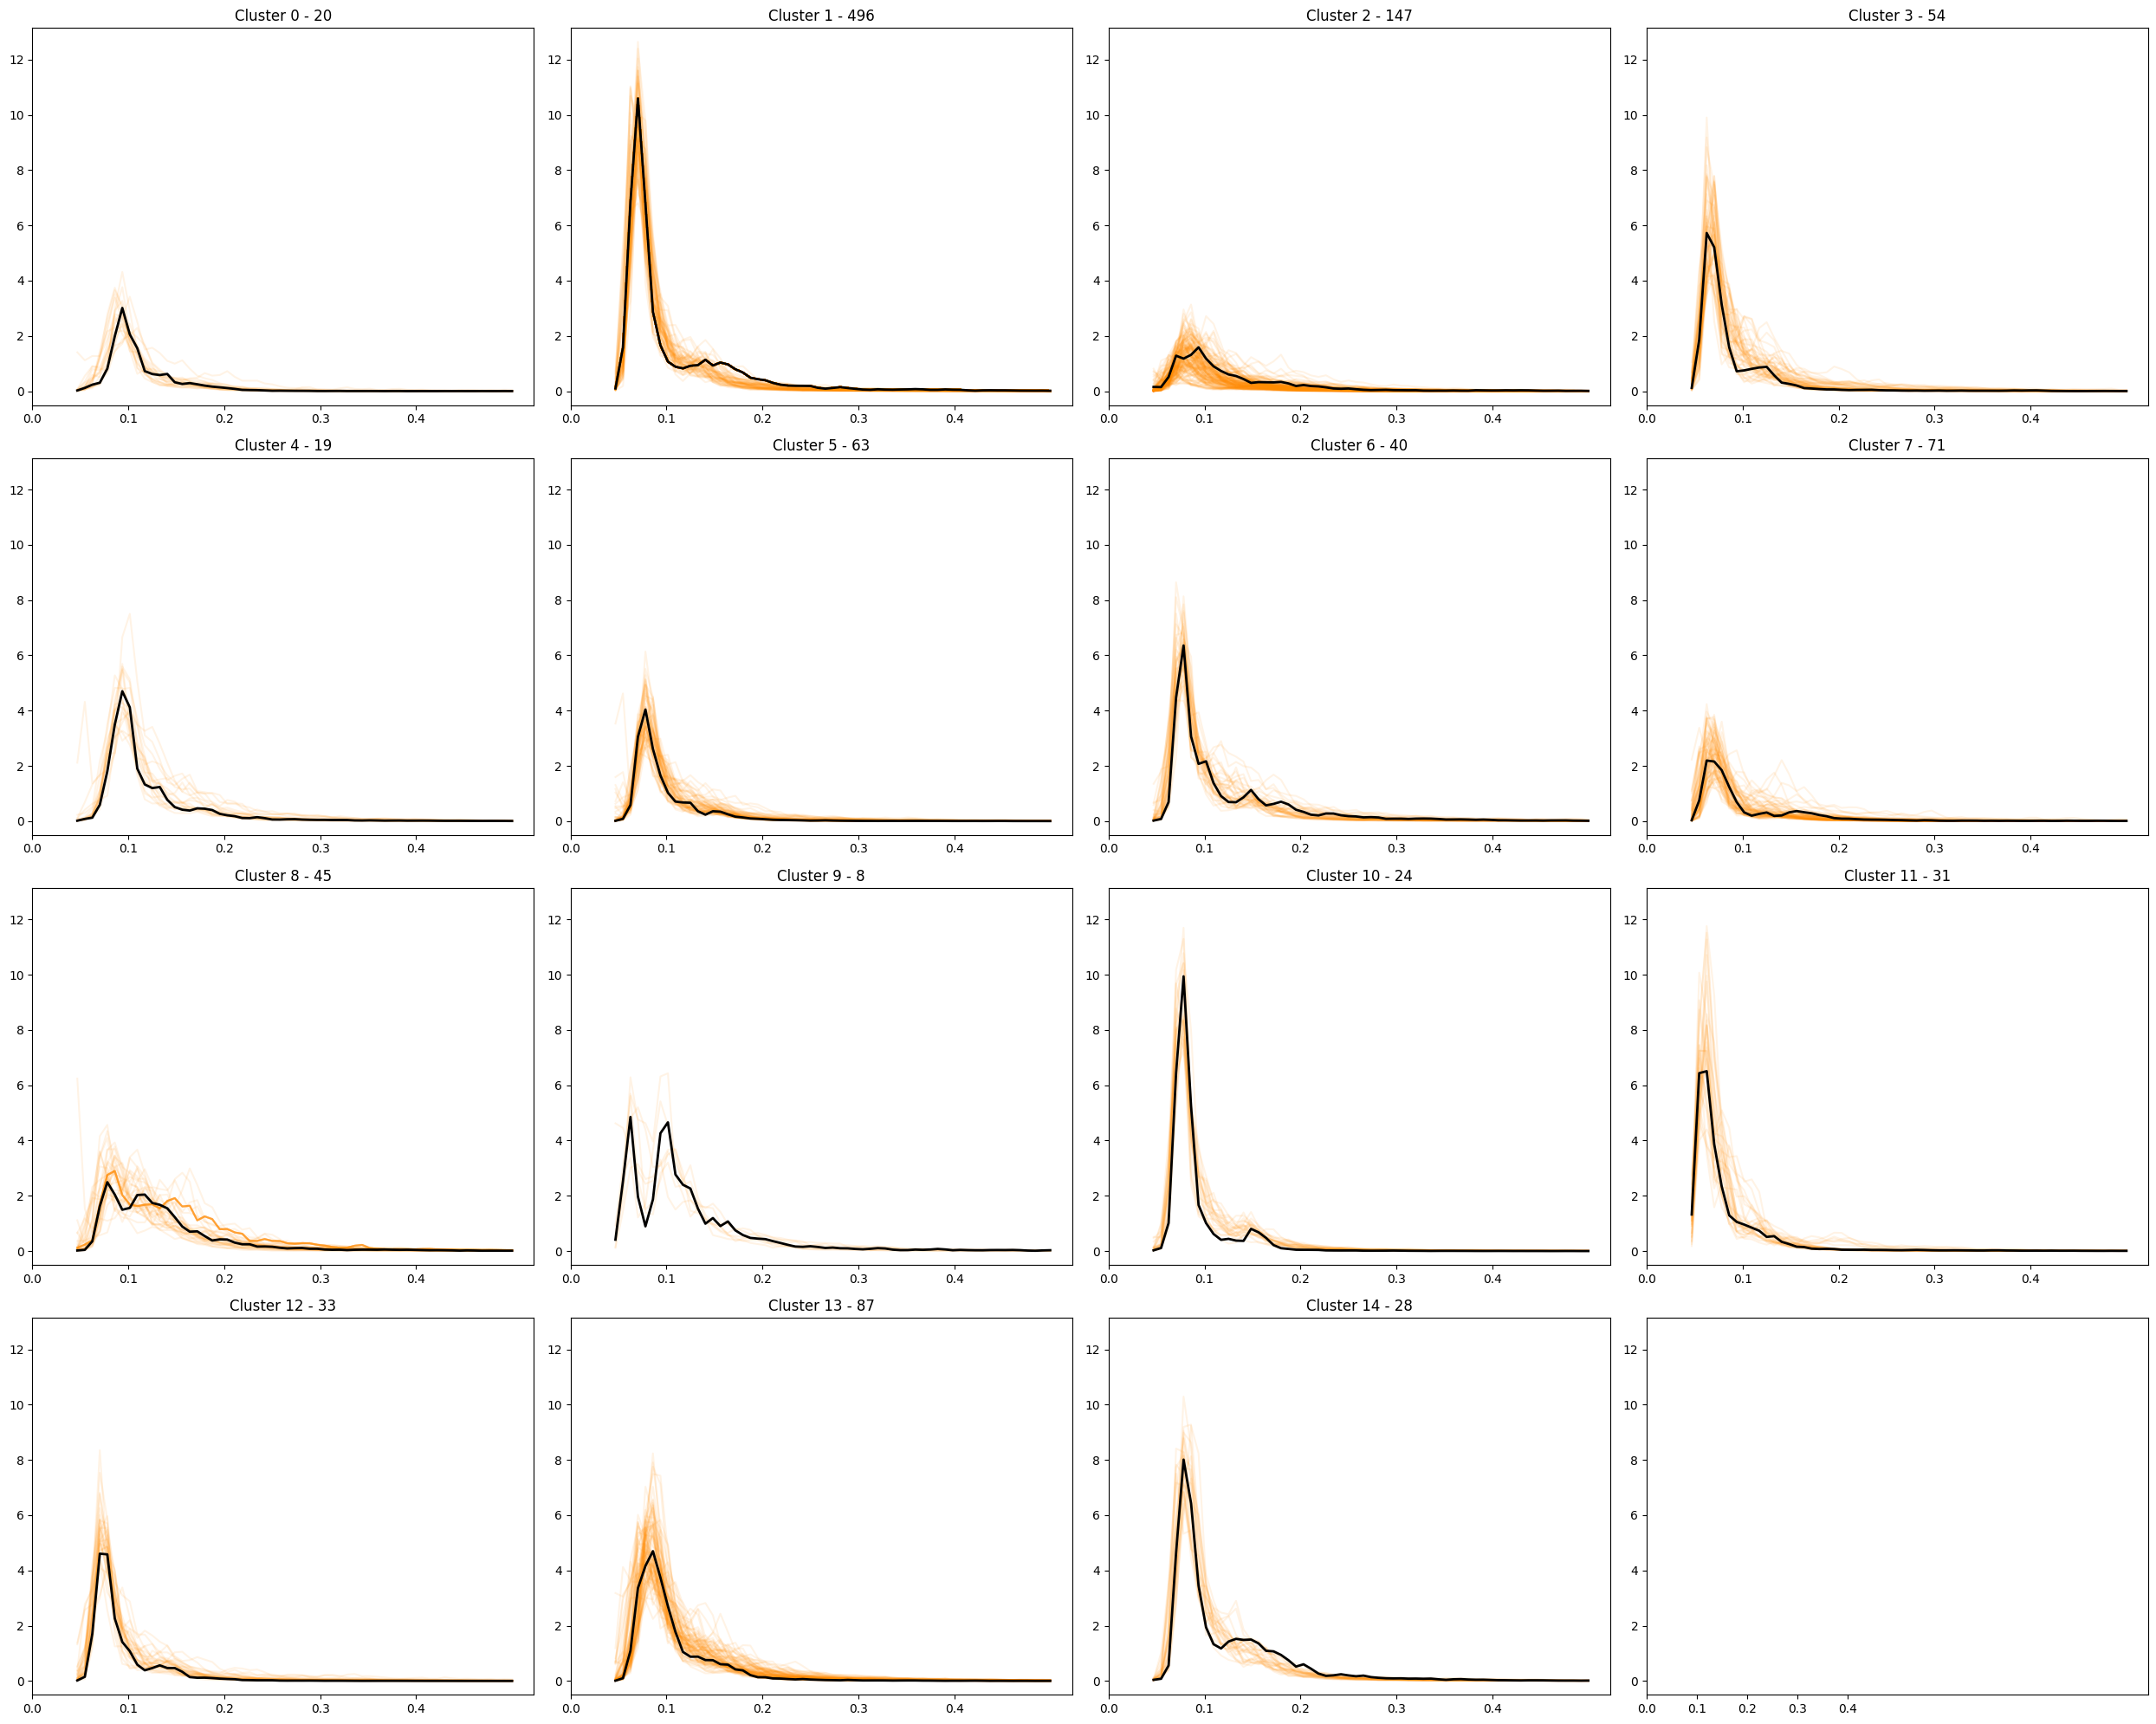

In [85]:
nc = 15
clara = CLARA(n_clusters=nc, random_state=42, max_iter=10000)
clara.fit(data_df)

labels = clara.labels_
centroids = clara.cluster_centers_
n_clusters = clara.n_clusters

num_cols = int(np.ceil(np.sqrt(nc)))
num_rows = int(np.ceil(nc / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
axes = axes.flatten()

for cluster_num in range(n_clusters):
    
    cluster_points = data_df[labels == cluster_num]
    ax = axes[cluster_num]
    

    for row in cluster_points.values:
        ax.plot(freq, row, color='darkorange', alpha=0.1)
    
    ax.plot(freq, centroids[cluster_num, :], color='black', linewidth=2, label=f'Centroide Cluster {cluster_num}')
    num_ondas = cluster_points.shape[0]
    ax.set_title(f'Cluster {cluster_num} - {num_ondas}')
    

for ax in fig.get_axes():
            ax.set_ylim(np.min(data_df)-0.5, np.max(data_df) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))

plt.tight_layout()
plt.show()